In [6]:
from collections import Counter
from torch_geometric.data import Dataset

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from src.generation.generation import HDCGenerator


def _to_scalar(x):
    if isinstance(x, torch.Tensor):
        return float(x.detach().cpu().reshape(-1)[0])
    return float(x)


def _stats(arr):
    arr = np.asarray(arr)
    return {
        "min": float(np.min(arr)) if arr.size else None,
        "max": float(np.max(arr)) if arr.size else None,
        "mean": float(np.mean(arr)) if arr.size else None,
        "median": float(np.median(arr)) if arr.size else None,
        "std": float(np.std(arr, ddof=1)) if arr.size > 1 else 0.0,
        "n": int(arr.size),
    }


def _stack_terms(terms_list):
    """
    Convert a list of 1D tensors/arrays to shape [N, D] float32 numpy array.
    Skips entries that are None or empty.
    """
    clean = []
    for t in terms_list:
        if t is None:
            continue
        if isinstance(t, torch.Tensor):
            t = t.detach().cpu()
        t = np.asarray(t, dtype=np.float32).reshape(-1)
        if t.size > 0:
            clean.append(t)
    if not clean:
        return None
    # Ensure consistent D
    D = min(len(x) for x in clean)
    if any(len(x) != D for x in clean):
        clean = [x[:D] for x in clean]
    return np.stack(clean, axis=0)  # [N, D]


def _plot_terms_overview(terms_nd: np.ndarray, title: str):
    """
    Plot mean ± std over dimensions for a [N, D] matrix.
    """
    dims = np.arange(terms_nd.shape[1])
    mu = terms_nd.mean(axis=0)
    sd = terms_nd.std(axis=0, ddof=1) if terms_nd.shape[0] > 1 else np.zeros_like(mu)

    plt.figure(figsize=(10, 4))
    plt.plot(dims, mu, linewidth=1.0)
    plt.fill_between(dims, mu - sd, mu + sd, alpha=0.2)
    plt.title(f"{title}: per-dimension mean ± std")
    plt.xlabel("dimension")
    plt.ylabel("value")
    plt.tight_layout()
    plt.show()


def _plot_topk_dim_hists(terms_nd: np.ndarray, title: str, top_k: int = 12, bins: int = 50):
    """
    Small multiples: histograms for the top-k most variant dimensions.
    """
    if terms_nd.shape[0] == 0:
        return
    sd = terms_nd.std(axis=0, ddof=1) if terms_nd.shape[0] > 1 else np.zeros(terms_nd.shape[1])
    top_idx = np.argsort(sd)[::-1][:top_k]

    ncols = 4
    nrows = int(np.ceil(top_k / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.0 * ncols, 2.4 * nrows))
    axes = np.array(axes).reshape(nrows, ncols)

    for i, ax in enumerate(axes.flat):
        if i >= len(top_idx):
            ax.axis("off")
            continue
        d = top_idx[i]
        ax.hist(terms_nd[:, d], bins=bins)
        ax.set_title(f"dim {int(d)} (σ={sd[d]:.3f})", fontsize=9)
        ax.tick_params(labelsize=8)
    fig.suptitle(f"{title}: top-{len(top_idx)} variant dims", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()


def _write_all_dim_hist_pdf(terms_nd: np.ndarray, pdf_path: str, bins: int = 50, title: str = ""):
    """
    Optional: write one histogram per dimension to a multi-page PDF.
    """
    if terms_nd is None:
        return
    D = terms_nd.shape[1]
    with PdfPages(pdf_path) as pdf:
        for d in range(D):
            plt.figure(figsize=(4, 3))
            plt.hist(terms_nd[:, d], bins=bins)
            plt.title(f"{title} dim {d}")
            plt.xlabel("value")
            plt.ylabel("frequency")
            plt.tight_layout()
            pdf.savefig()
            plt.close()


def analyze_dataset(
        ds: Dataset,
        name: str = "",
        feature_attr: str = "x",
        top_k_term_dims: int = 12,
        dump_all_dim_pdfs: bool = False,
        pdf_dir: str | None = None,
) -> dict:
    """
    Compute statistics for a PyG dataset with 4-tuple node features and draw:
      - histograms for node counts, edge counts, and node-type distribution,
      - (if present) logP/QED/SA histograms,
      - (if present) graph_terms / edge_terms / node_terms overview plots
        (mean ± std across dimensions) + top-K per-dimension histograms.

    Parameters
    ----------
    ds : torch_geometric.data.Dataset
        The dataset to analyze.
    name : str
        Label for plots and summary.
    feature_attr : str
        Node feature field name, expected shape [N, 4].
    top_k_term_dims : int
        Number of per-dimension histograms to show (by highest std).
    dump_all_dim_pdfs : bool
        If True, write a multi-page PDF with a histogram for every dimension.
    pdf_dir : str | None
        Directory to write PDFs to (required if dump_all_dim_pdfs=True).

    Returns
    -------
    dict
        Summary statistics.
    """
    num_nodes_list, num_edges_list = [], []
    node_type_counter = Counter()
    logp_list: list[float] = []
    qed_list: list[float] = []
    sa_list: list[float] = []

    graph_terms_list: list[np.ndarray] = []
    edge_terms_list: list[np.ndarray] = []
    node_terms_list: list[np.ndarray] = []

    for data in ds:
        n = int(data.num_nodes)
        e = int(data.num_edges) // 2  # dataset is undirected
        num_nodes_list.append(n)
        num_edges_list.append(e)

        x: torch.Tensor = getattr(data, feature_attr)
        if x.dim() != 2 or x.size(1) != 4:
            raise ValueError(f"Expected {feature_attr} shape [N, 4], got {tuple(x.shape)}")
        rows = x.detach().cpu().to(torch.int64).tolist()
        node_type_counter.update(map(tuple, rows))

        if hasattr(data, "logp"):
            logp_list.append(_to_scalar(data.logp))
        if hasattr(data, "qed"):
            qed_list.append(_to_scalar(data.qed))
        if hasattr(data, "sa_score"):
            sa_list.append(_to_scalar(data.sa_score))

        # Collect terms if present (assumed 1D: [D])
        gt = getattr(data, "graph_terms", None)
        et = getattr(data, "edge_terms", None)
        nt = getattr(data, "node_terms", None)
        graph_terms_list.append(gt if gt is not None else None)
        edge_terms_list.append(et if et is not None else None)
        node_terms_list.append(nt if nt is not None else None)

    summary = {
        "dataset": name,
        "num_graphs": len(ds),
        "nodes": _stats(num_nodes_list),
        "edges": _stats(num_edges_list),
        "total_node_types": len(node_type_counter),
        "node_type_distribution": dict(node_type_counter),
    }
    if logp_list:
        summary["logp"] = _stats(logp_list)
    if qed_list:
        summary["qed"] = _stats(qed_list)
    if sa_list:
        summary["sa_score"] = _stats(sa_list)

    # --- plotting: counts + node types ---
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 3])
    ax_nodes = fig.add_subplot(gs[0, 0])
    ax_edges = fig.add_subplot(gs[0, 1])
    ax_types = fig.add_subplot(gs[1, :])
    plt.subplots_adjust(bottom=0.25)

    ax_nodes.hist(num_nodes_list, bins=30)
    ax_nodes.set_title(f"{name} – Node count distribution")
    ax_nodes.set_xlabel("num_nodes")
    ax_nodes.set_ylabel("frequency")

    ax_edges.hist(num_edges_list, bins=30)
    ax_edges.set_title(f"{name} – Edge count distribution")
    ax_edges.set_xlabel("num_edges")
    ax_edges.set_ylabel("frequency")

    if node_type_counter:
        labels, counts = zip(*node_type_counter.most_common())
        ax_types.bar(range(len(labels)), counts)
        ax_types.set_xticks(range(len(labels)))
        ax_types.set_xticklabels([str(l) for l in labels], rotation=90, fontsize=8)
    ax_types.set_title(f"{name} – Node type distribution")
    ax_types.set_xlabel("node type (tuple)")
    ax_types.set_ylabel("count")

    plt.tight_layout()
    plt.show()

    # --- scalar property histograms ---
    if logp_list:
        plt.figure(figsize=(8, 5))
        plt.hist(logp_list, bins=100)
        plt.title(f"{name} – logP distribution")
        plt.xlabel("cLogP (RDKit)")
        plt.ylabel("frequency")
        plt.tight_layout()
        plt.show()

    if qed_list:
        plt.figure(figsize=(8, 5))
        plt.hist(qed_list, bins=100)
        plt.title(f"{name} – QED distribution")
        plt.xlabel("QED")
        plt.ylabel("frequency")
        plt.tight_layout()
        plt.show()

    if sa_list:
        plt.figure(figsize=(8, 5))
        plt.hist(sa_list, bins=100)
        plt.title(f"{name} – SA score distribution")
        plt.xlabel("SA score")
        plt.ylabel("frequency")
        plt.tight_layout()
        plt.show()

    # --- terms: overview + top-k per-dim hists (+ optional full PDF) ---
    g_nd = _stack_terms(graph_terms_list)
    e_nd = _stack_terms(edge_terms_list)
    n_nd = _stack_terms(node_terms_list)

    terms_meta = {}
    for label, arr in (("graph_terms", g_nd), ("edge_terms", e_nd), ("node_terms", n_nd)):
        if arr is None:
            continue
        N, D = arr.shape
        terms_meta[label] = {"N": int(N), "D": int(D)}
        _plot_terms_overview(arr, f"{name} – {label}")
        _plot_topk_dim_hists(arr, f"{name} – {label}", top_k=top_k_term_dims, bins=50)

        if dump_all_dim_pdfs:
            if not pdf_dir:
                raise ValueError("pdf_dir must be provided when dump_all_dim_pdfs=True")
            pdf_path = f"{pdf_dir.rstrip('/')}/{name}_{label}_all_dims.pdf"
            _write_all_dim_hist_pdf(arr, pdf_path=pdf_path, bins=50, title=f"{name} – {label}")
            terms_meta[label]["all_dim_pdf"] = pdf_path

    if terms_meta:
        summary["terms"] = terms_meta

    return summary


def _to_2d_ndarray(x):
    if x is None:
        return None
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    else:
        x = np.asarray(x)
    if x.ndim == 1:
        x = x.reshape(1, -1)
    if x.ndim != 2:
        raise ValueError(f"Expected 2D array, got shape {x.shape}")
    return x.astype(np.float32, copy=False)


def analyze_terms_only(
        terms: dict,
        name: str = "",
        top_k_term_dims: int = 12,
        dump_all_dim_pdfs: bool = False,
        pdf_dir: str | None = None,
) -> dict:
    terms_meta = {}
    for label in ("graph_terms", "edge_terms", "node_terms"):
        if label not in terms:
            continue
        arr = _to_2d_ndarray(terms.get(label))
        if arr is None:
            continue
        N, D = arr.shape
        terms_meta[label] = {"N": int(N), "D": int(D)}
        _plot_terms_overview(arr, f"{name} – {label}")
        _plot_topk_dim_hists(arr, f"{name} – {label}", top_k=top_k_term_dims, bins=50)
        if dump_all_dim_pdfs:
            if not pdf_dir:
                raise ValueError("pdf_dir must be provided when dump_all_dim_pdfs=True")
            pdf_path = f"{pdf_dir.rstrip('/')}/{name}_{label}_all_dims.pdf"
            _write_all_dim_hist_pdf(arr, pdf_path=pdf_path, bins=50, title=f"{name} – {label}")
            terms_meta[label]["all_dim_pdf"] = pdf_path
    return {"dataset": name, "terms": terms_meta}



## QM9_SMILES_HRR_1600_CONFIG_F64_G1G3_CONFIG

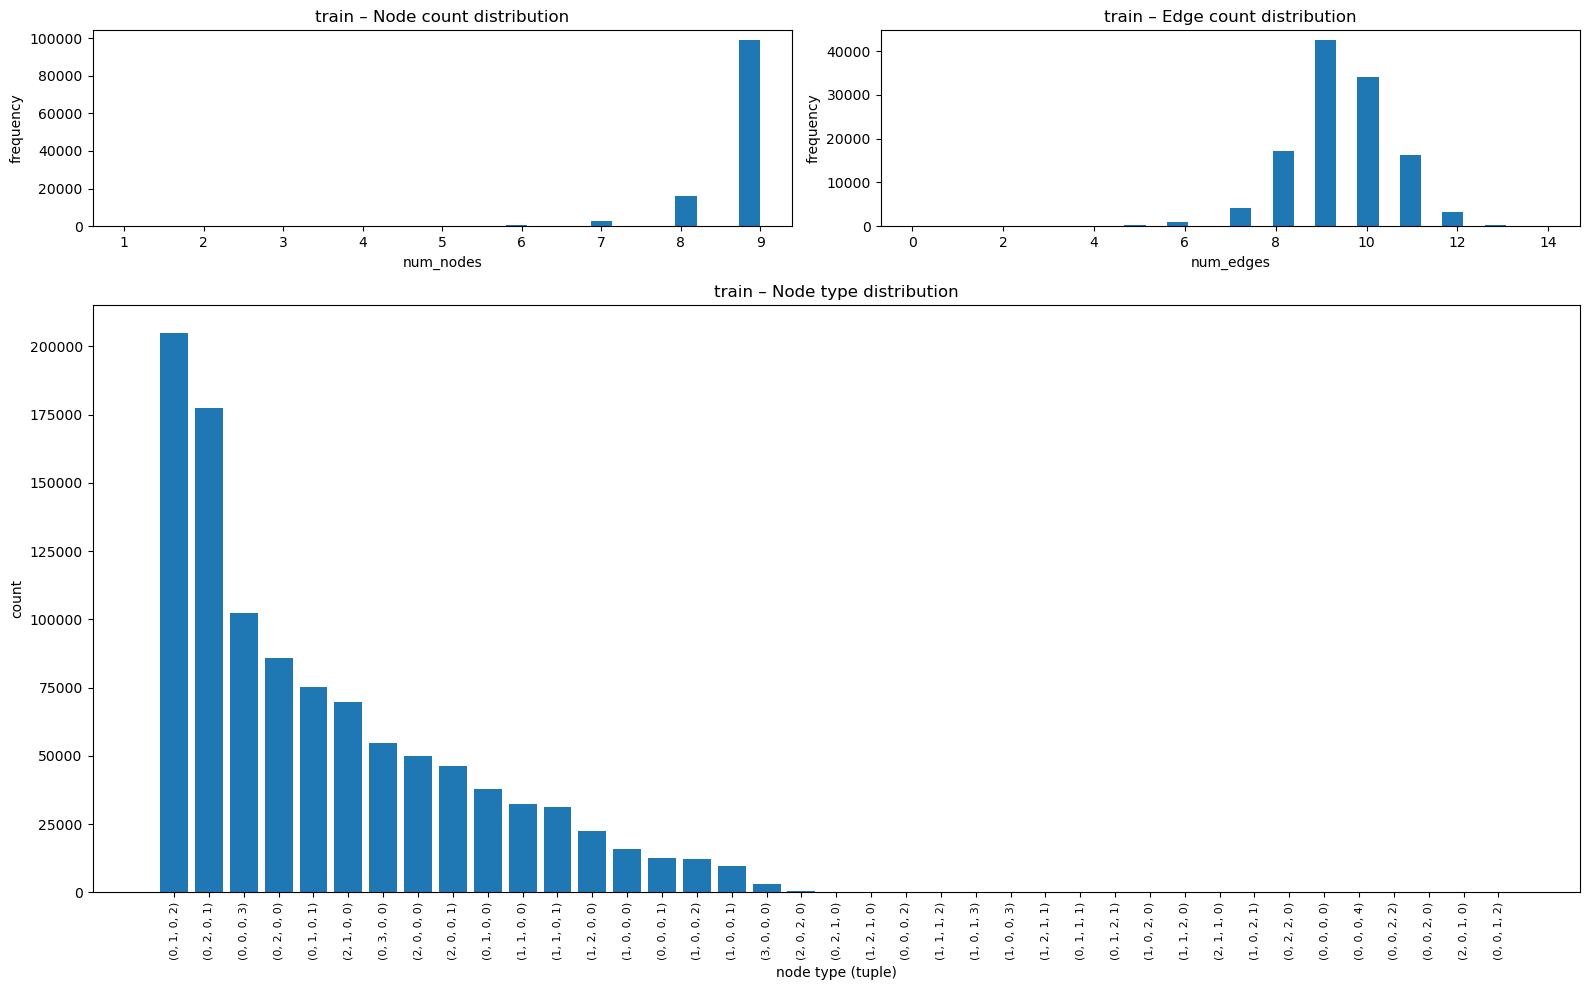

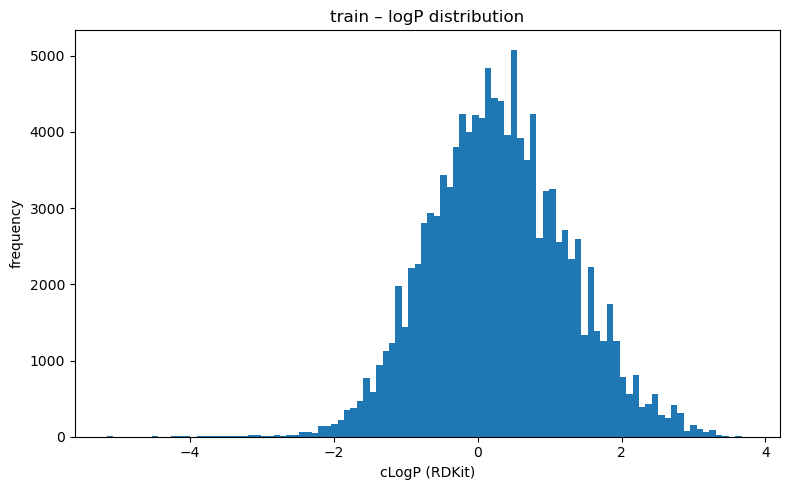

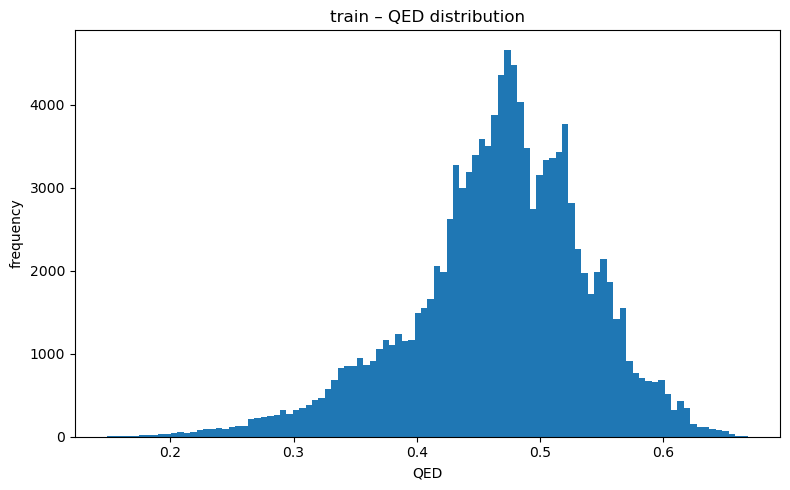

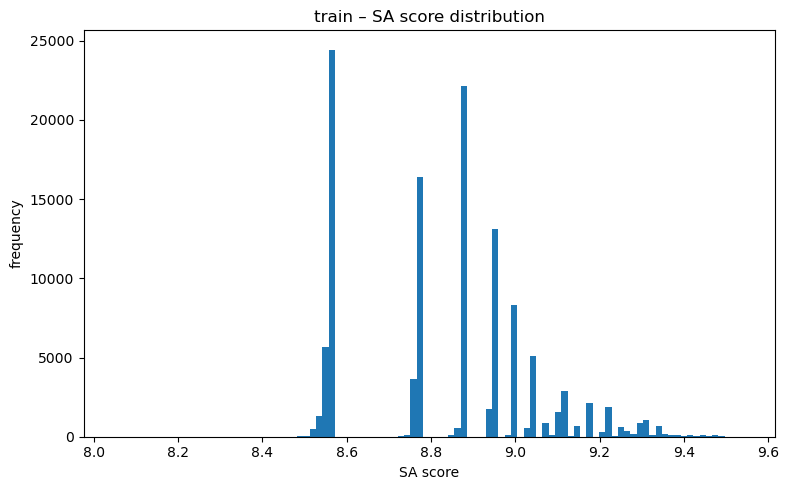

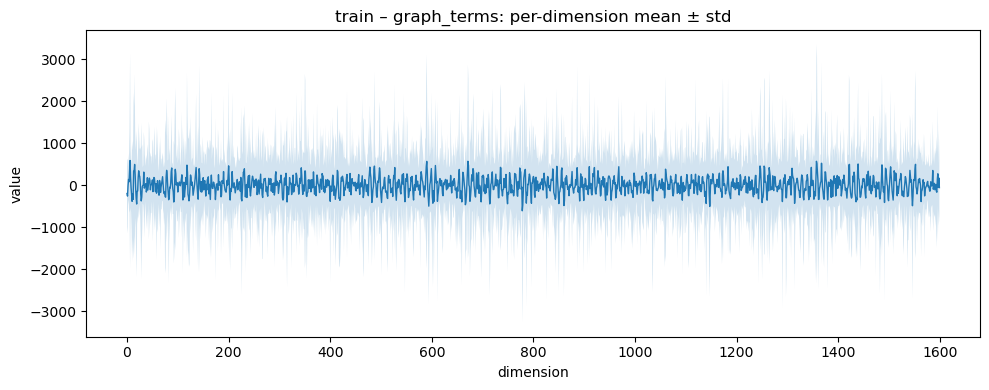

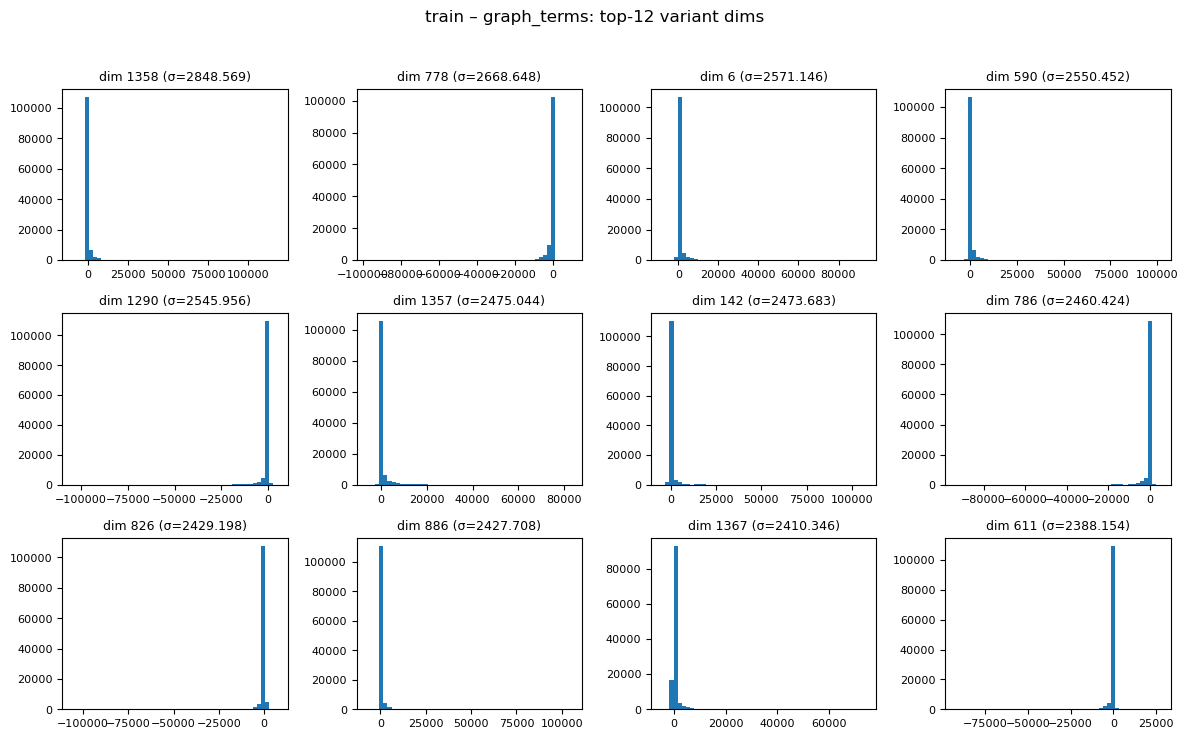

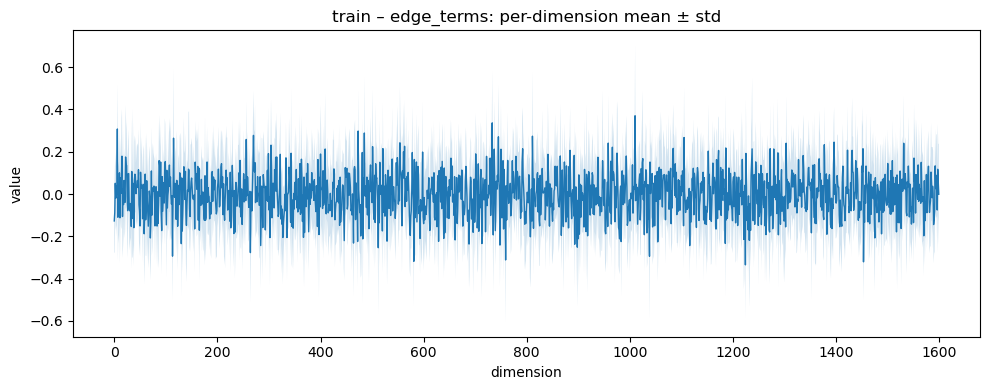

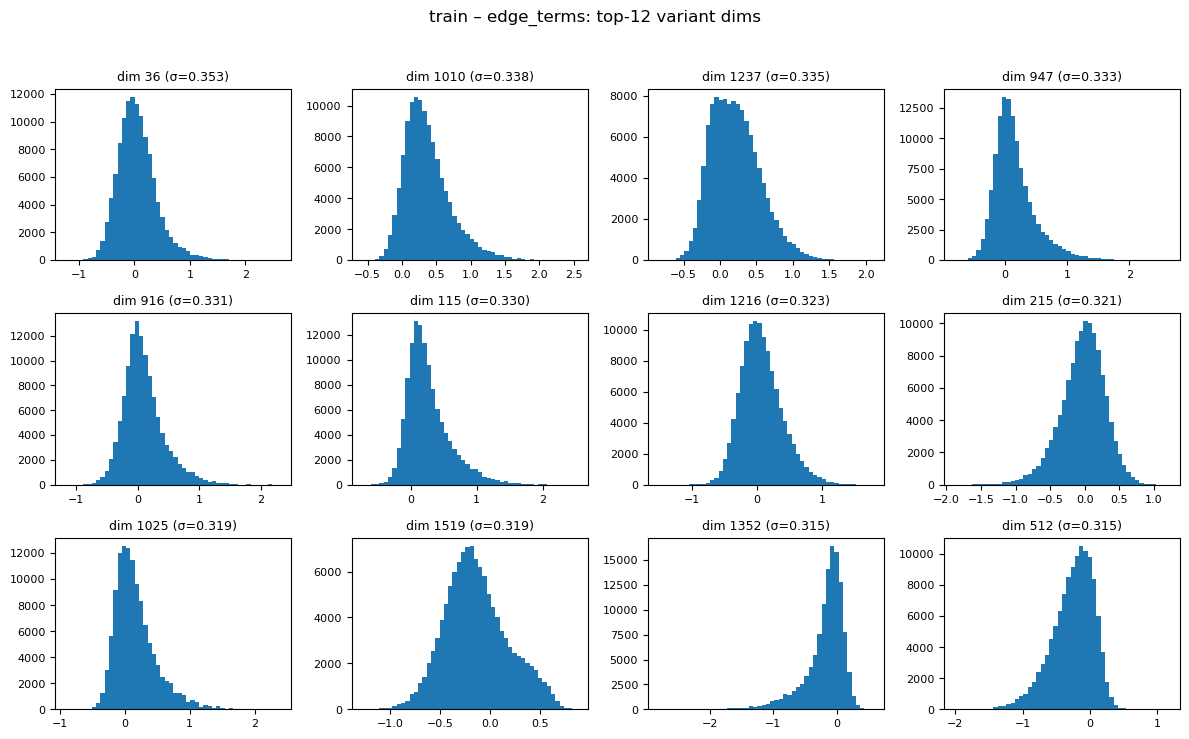

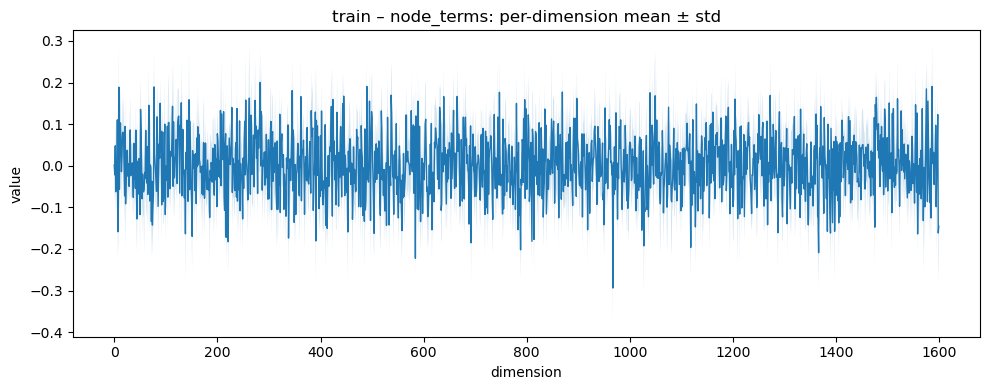

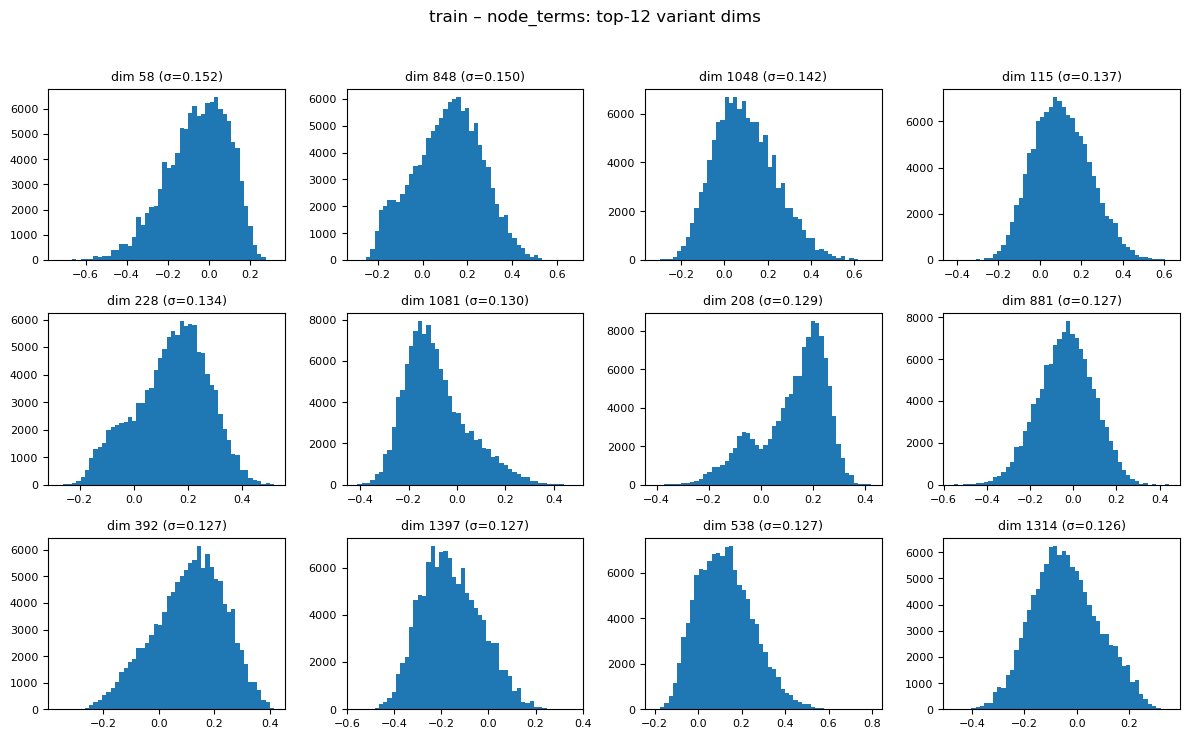

{'dataset': 'train',
 'edges': {'max': 14.0,
           'mean': 9.396537655935868,
           'median': 9.0,
           'min': 0.0,
           'n': 118879,
           'std': 1.1682700245850308},
 'logp': {'max': 3.7569000720977783,
          'mean': 0.30487121410781287,
          'median': 0.27810001373291016,
          'min': -5.1546101570129395,
          'n': 118879,
          'std': 0.9661976604136703},
 'node_type_distribution': {(0, 0, 0, 0): 2,
                            (0, 0, 0, 1): 12653,
                            (0, 0, 0, 2): 92,
                            (0, 0, 0, 3): 102500,
                            (0, 0, 0, 4): 1,
                            (0, 0, 1, 2): 1,
                            (0, 0, 2, 0): 1,
                            (0, 0, 2, 2): 1,
                            (0, 1, 0, 0): 37875,
                            (0, 1, 0, 1): 75277,
                            (0, 1, 0, 2): 204962,
                            (0, 1, 1, 1): 24,
                         

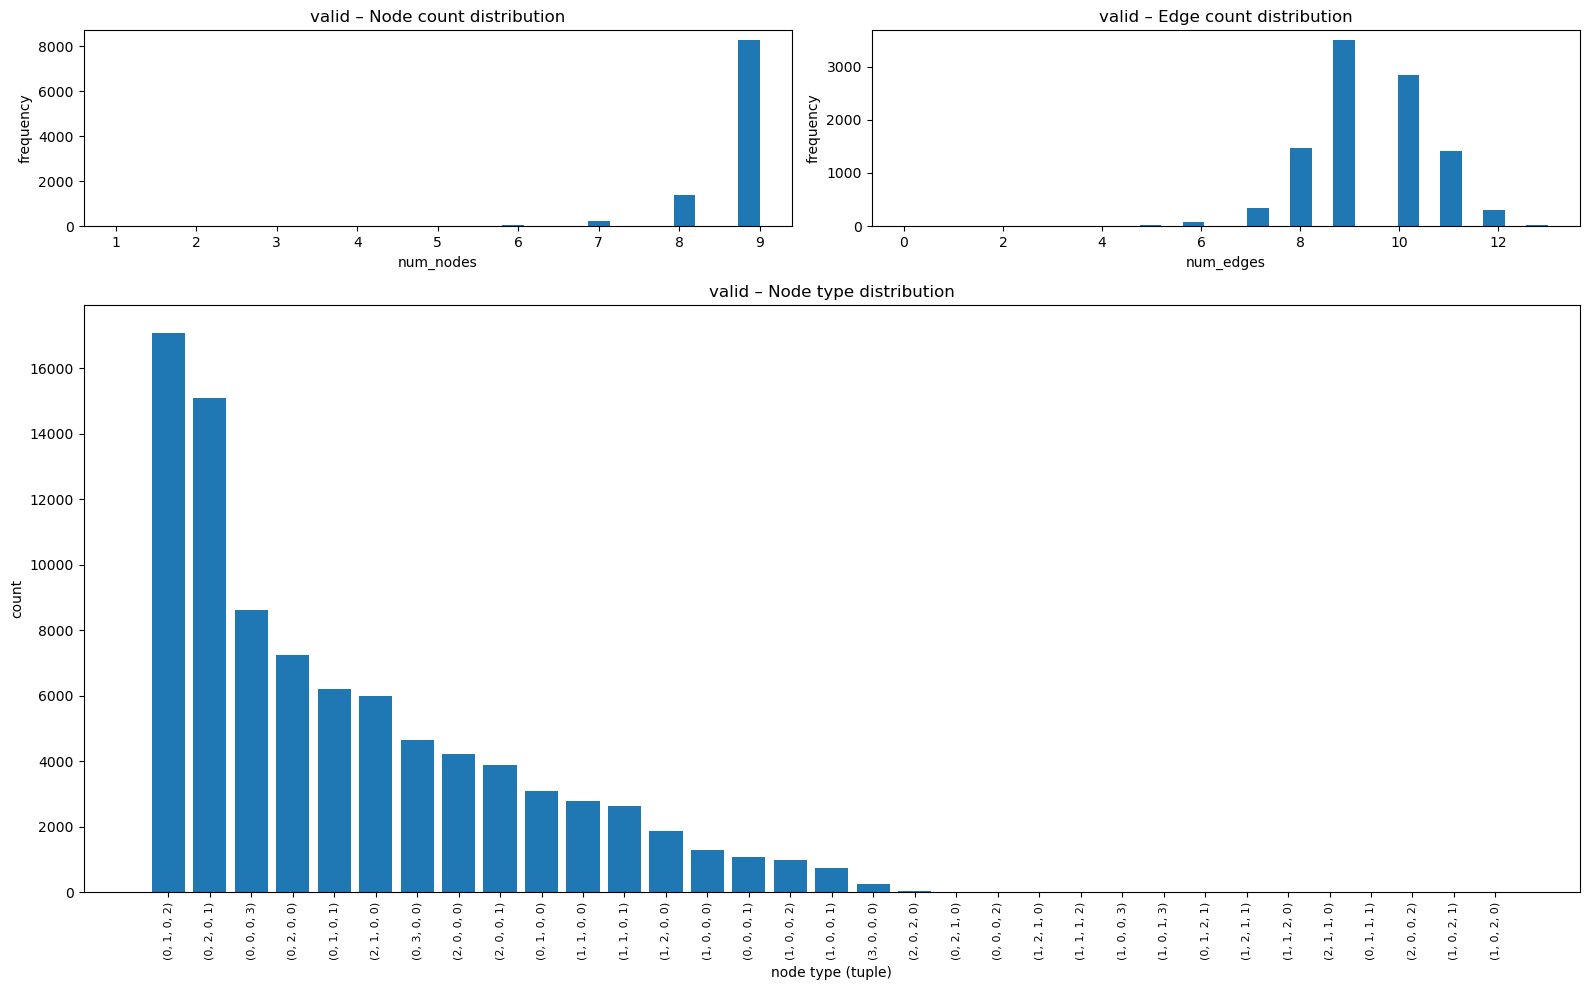

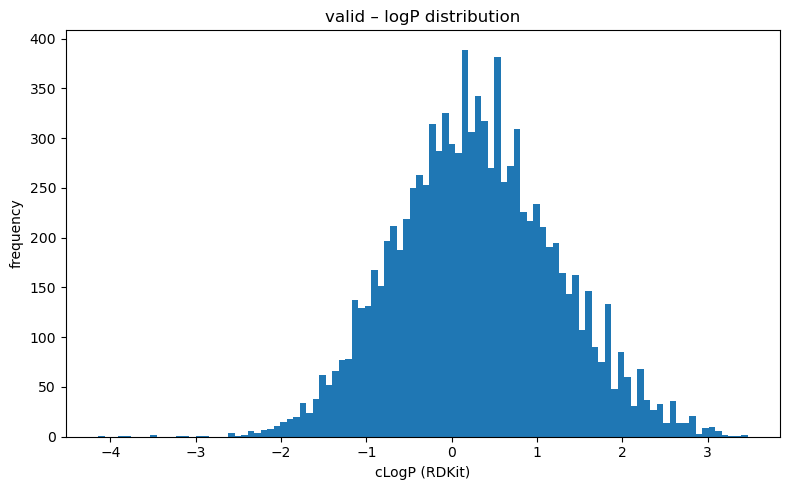

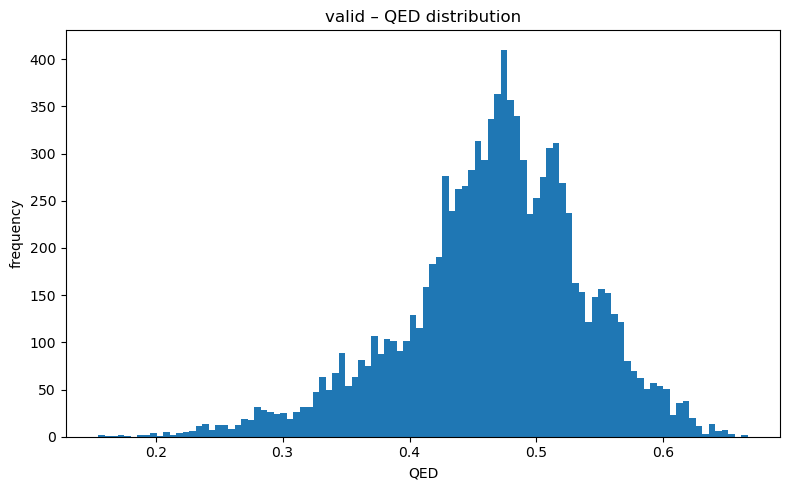

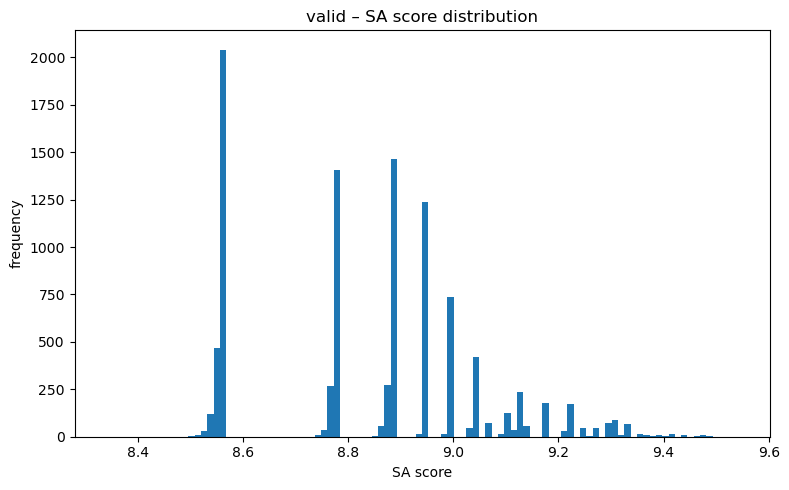

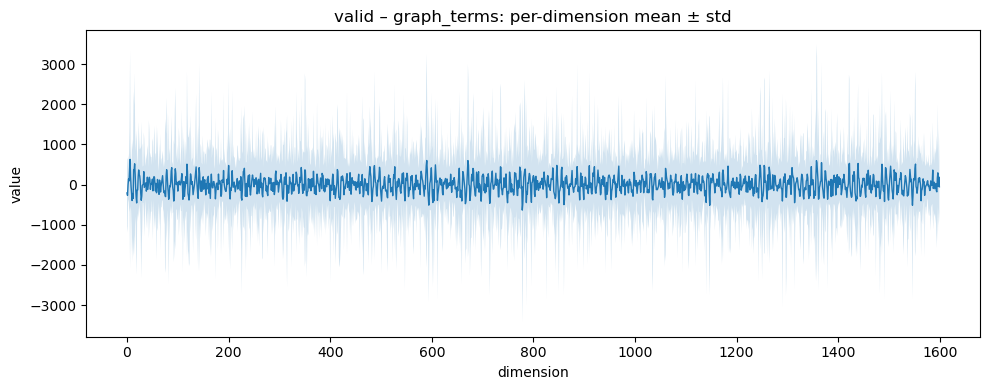

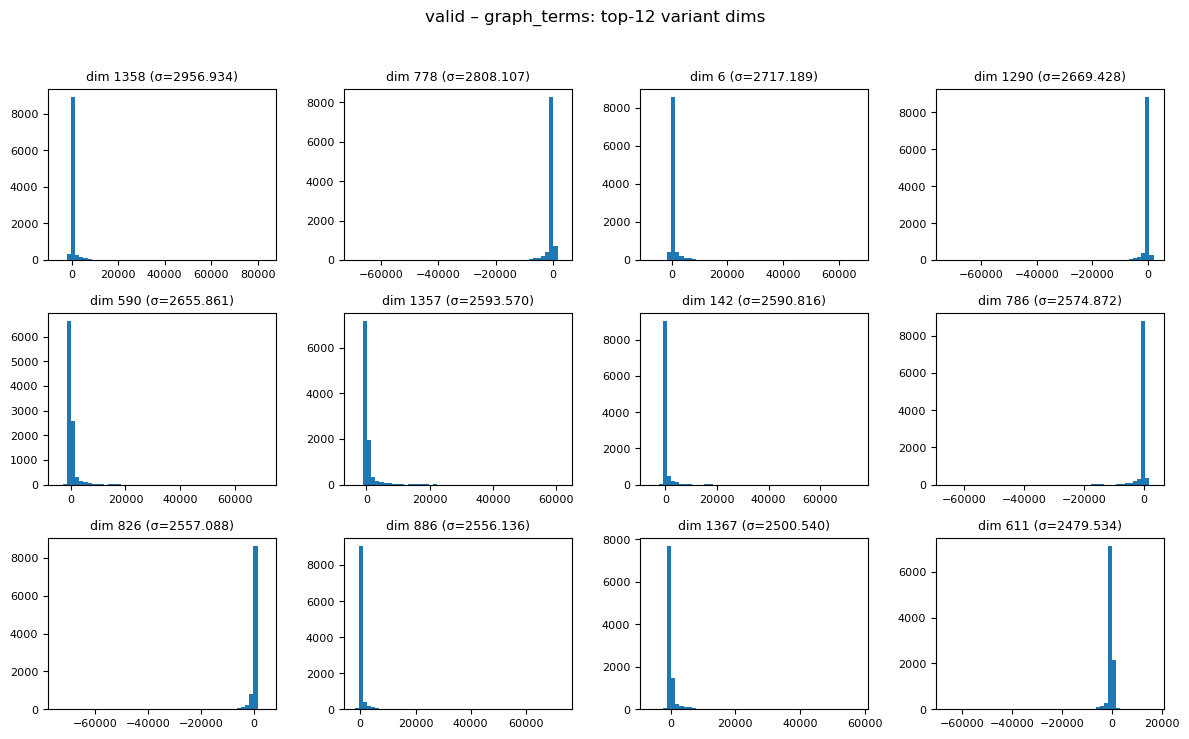

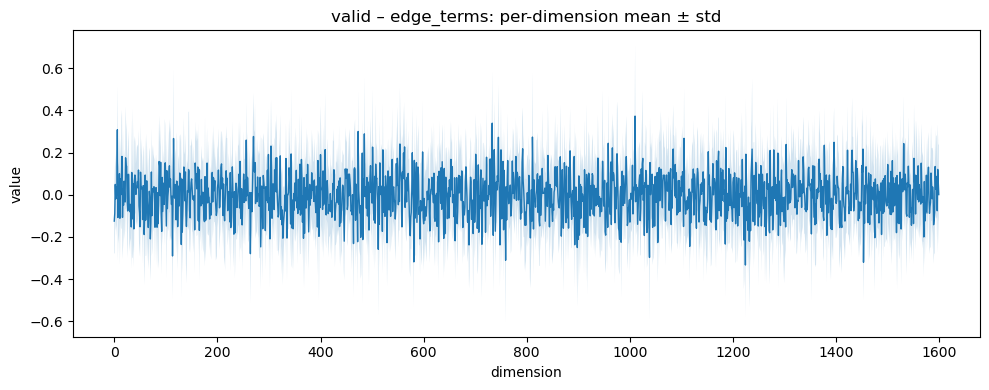

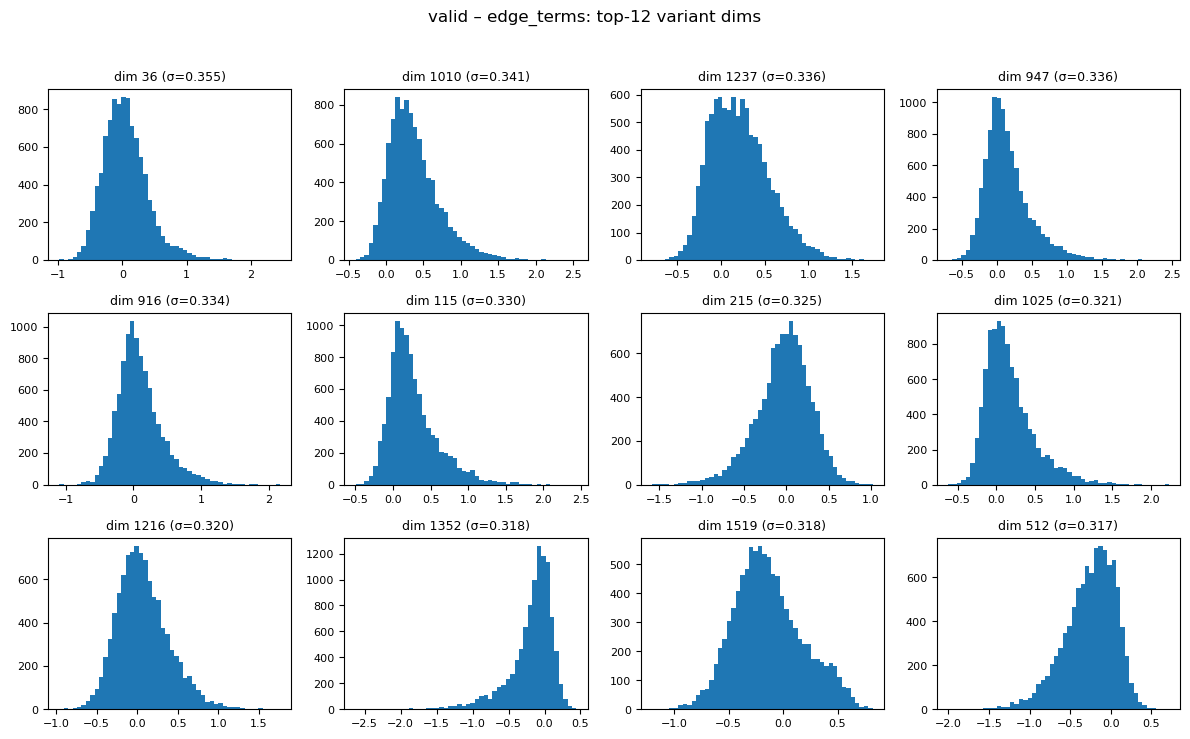

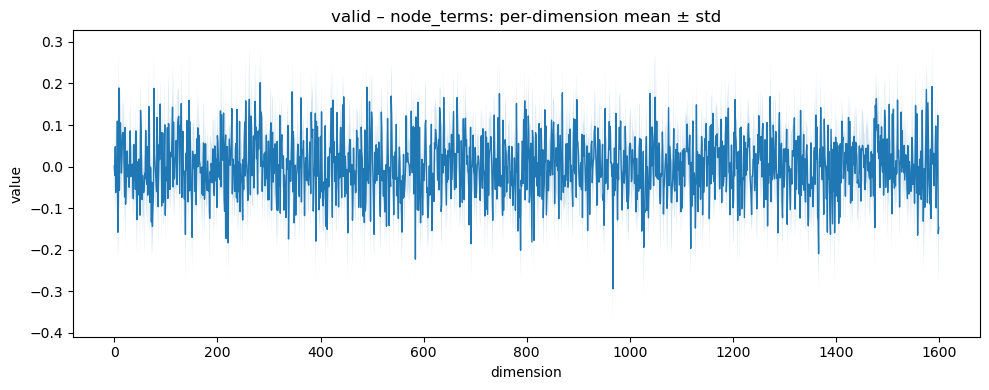

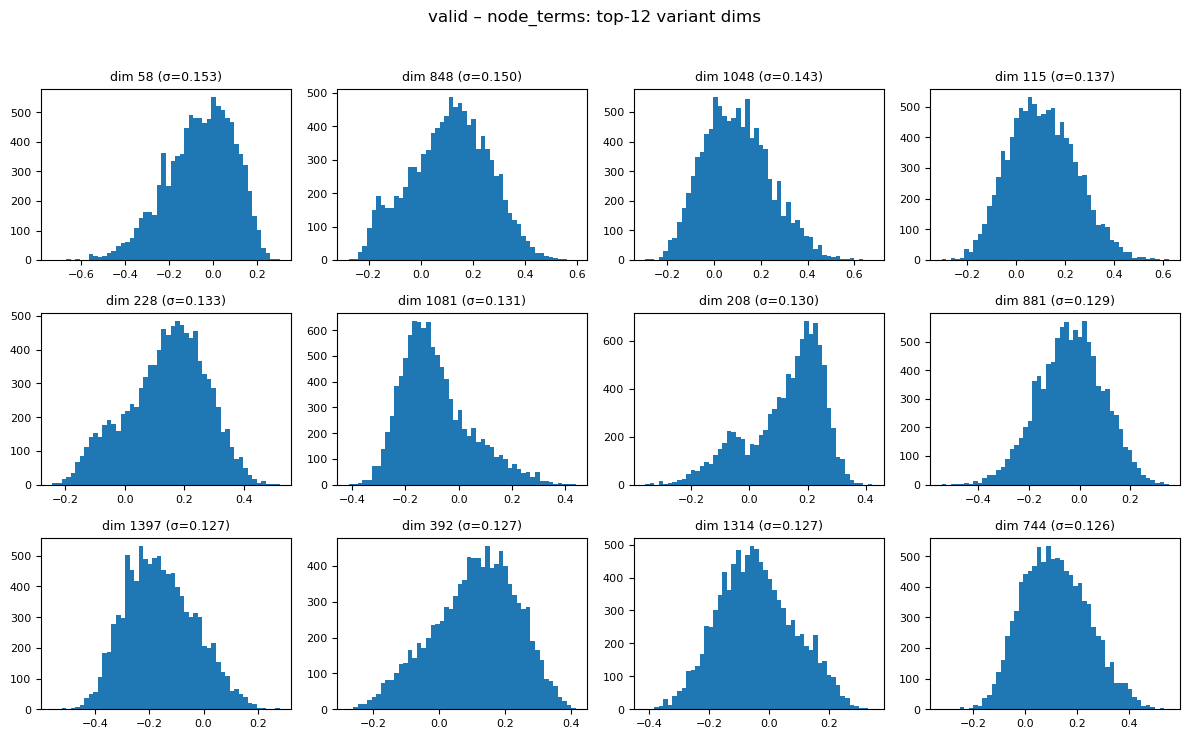

{'dataset': 'valid',
 'edges': {'max': 13.0,
           'mean': 9.411,
           'median': 9.0,
           'min': 0.0,
           'n': 10000,
           'std': 1.182716737806728},
 'logp': {'max': 3.4686999320983887,
          'mean': 0.2900216716815892,
          'median': 0.26197999715805054,
          'min': -4.140510082244873,
          'n': 10000,
          'std': 0.9493566984068311},
 'node_type_distribution': {(0, 0, 0, 1): 1084,
                            (0, 0, 0, 2): 12,
                            (0, 0, 0, 3): 8616,
                            (0, 1, 0, 0): 3105,
                            (0, 1, 0, 1): 6205,
                            (0, 1, 0, 2): 17084,
                            (0, 1, 1, 1): 1,
                            (0, 1, 2, 1): 2,
                            (0, 2, 0, 0): 7249,
                            (0, 2, 0, 1): 15105,
                            (0, 2, 1, 0): 13,
                            (0, 3, 0, 0): 4649,
                            (1, 0, 0, 

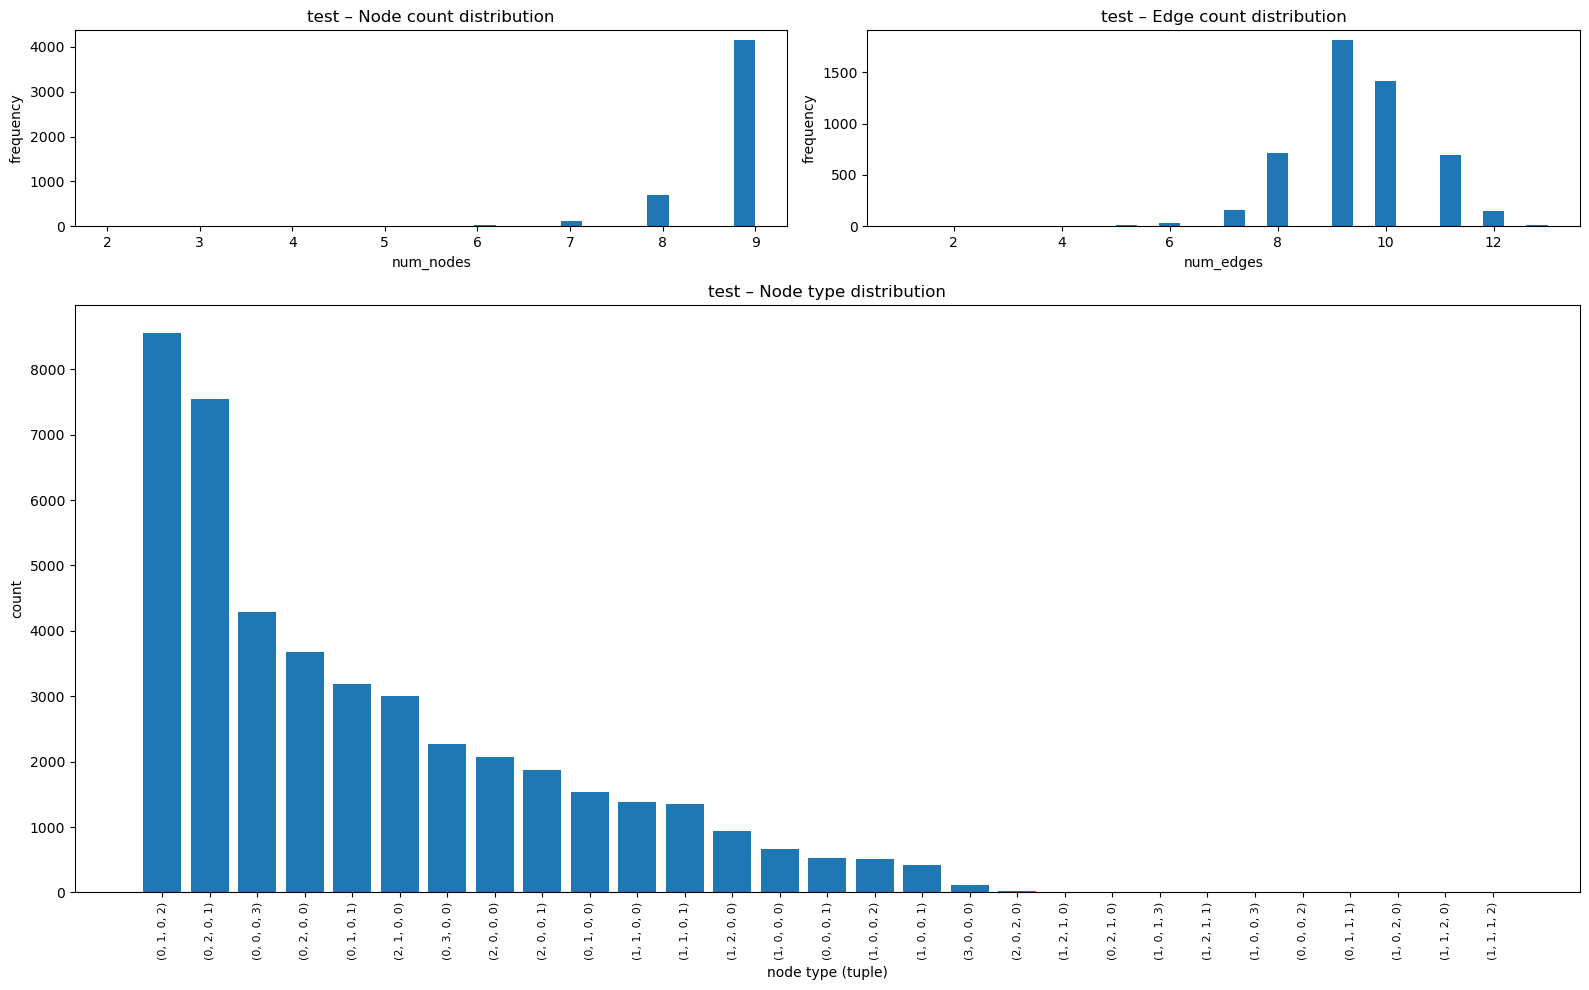

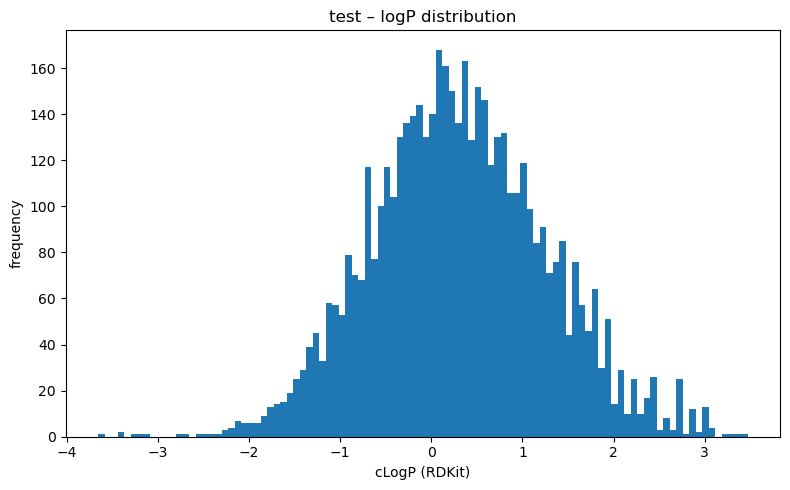

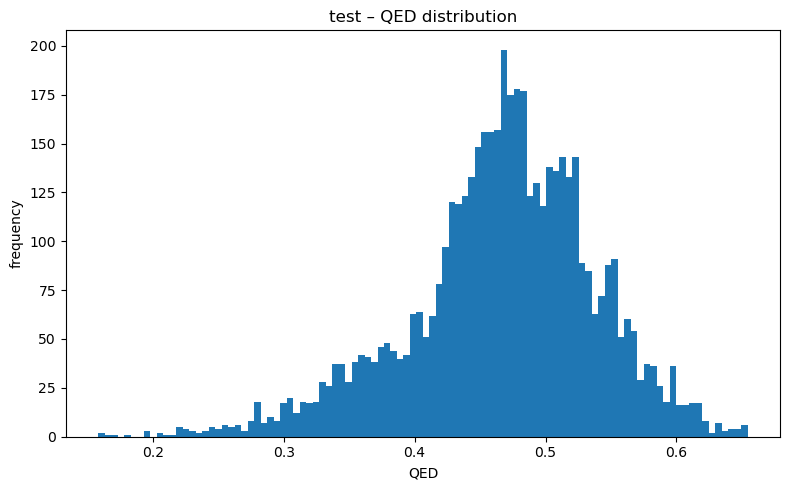

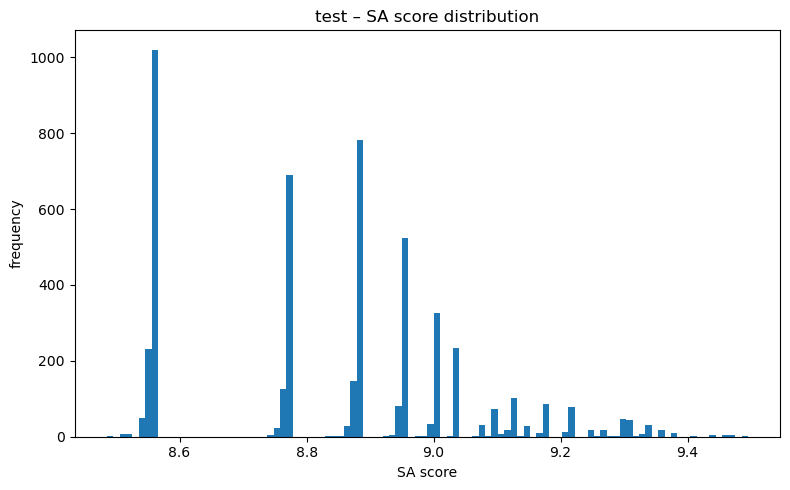

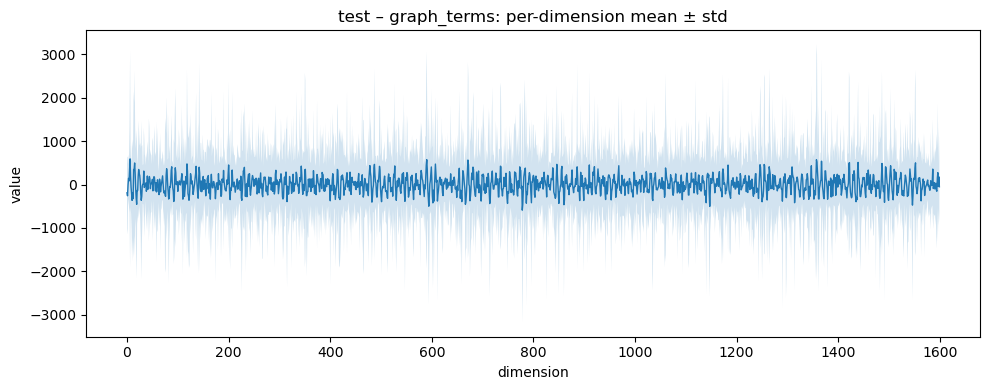

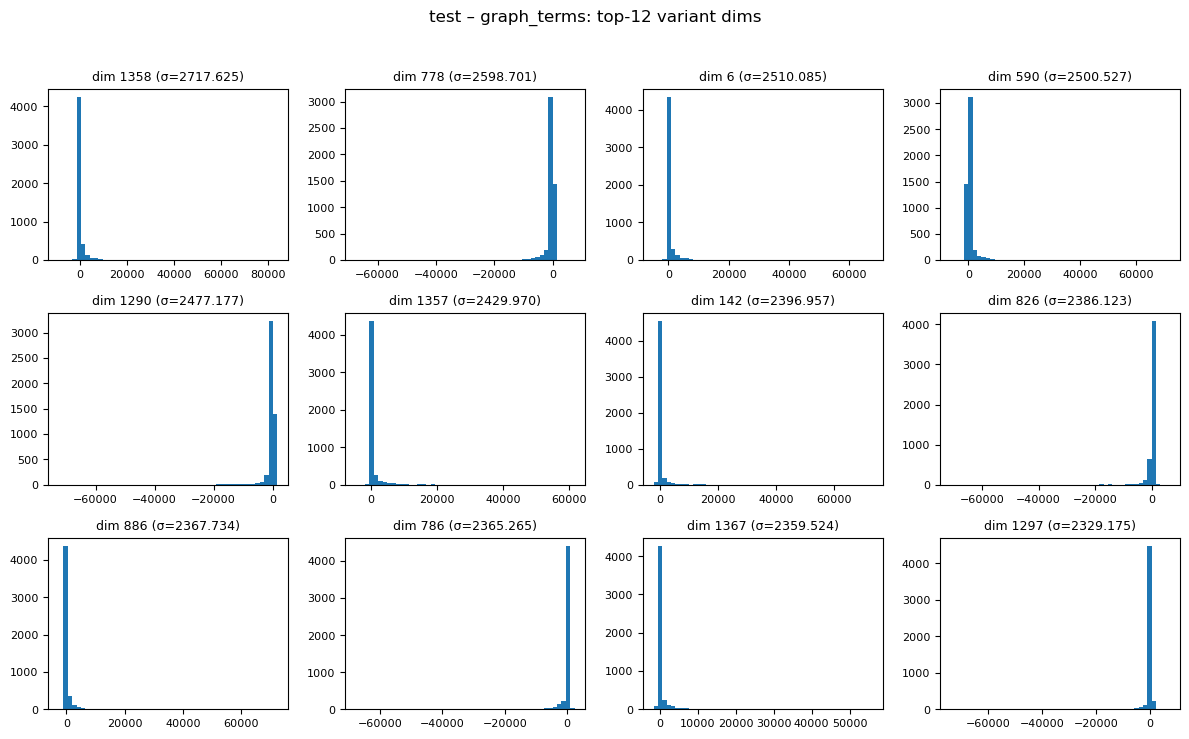

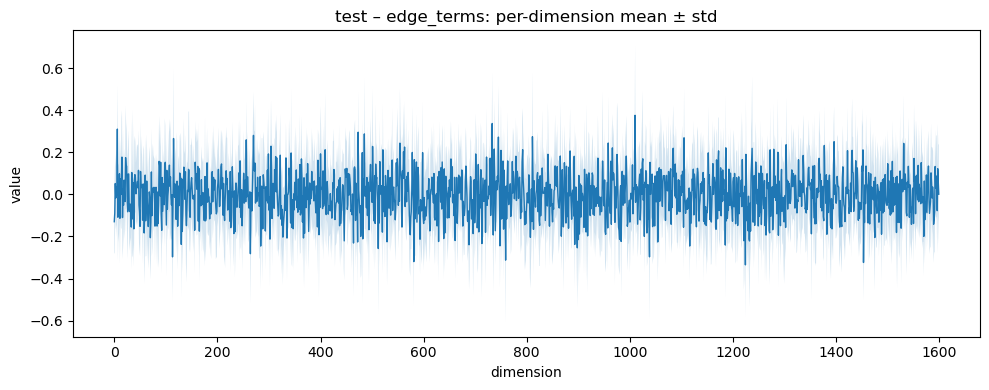

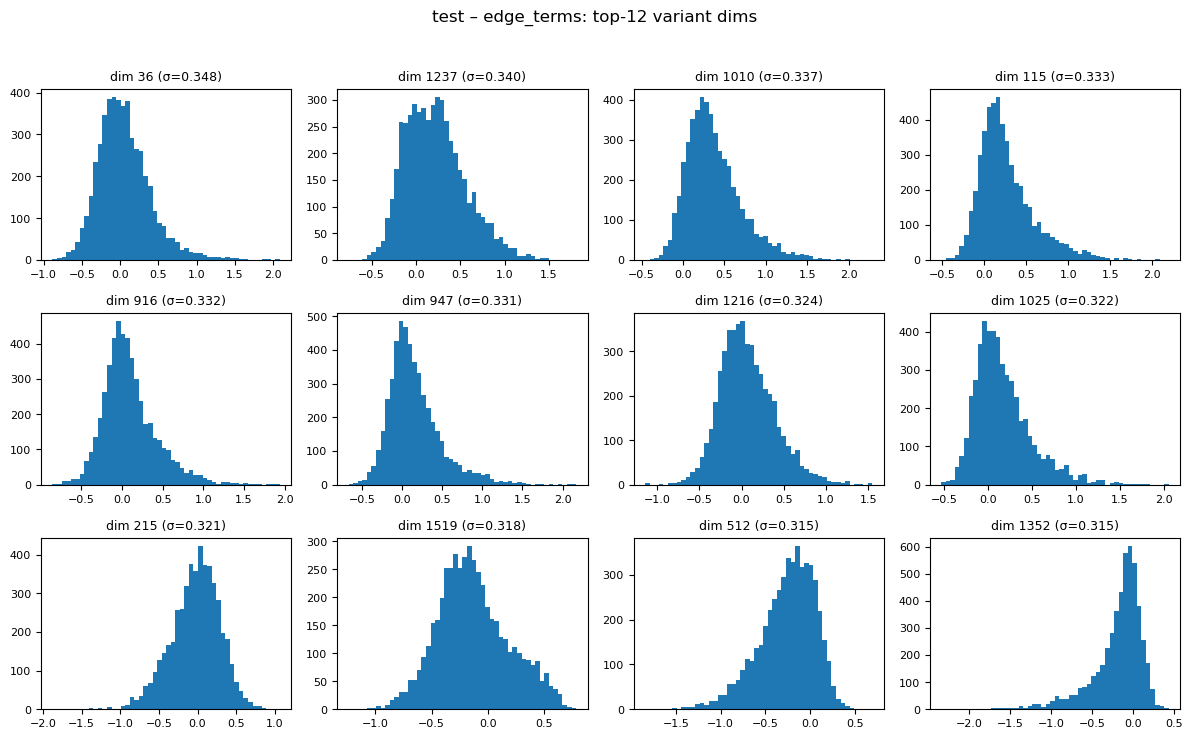

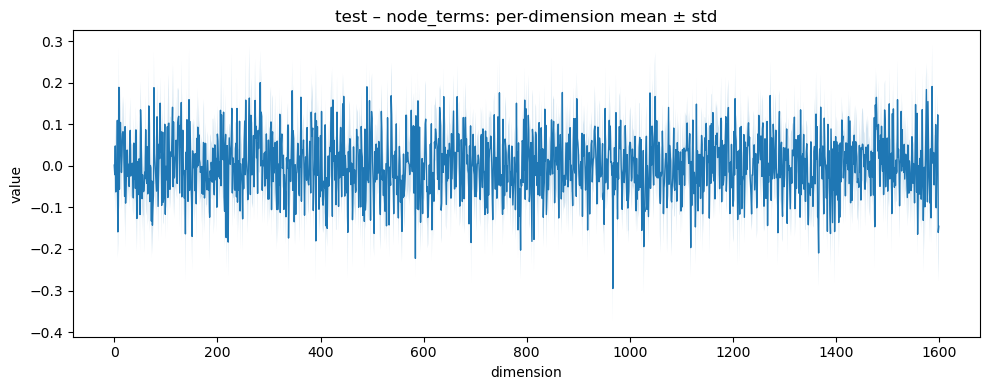

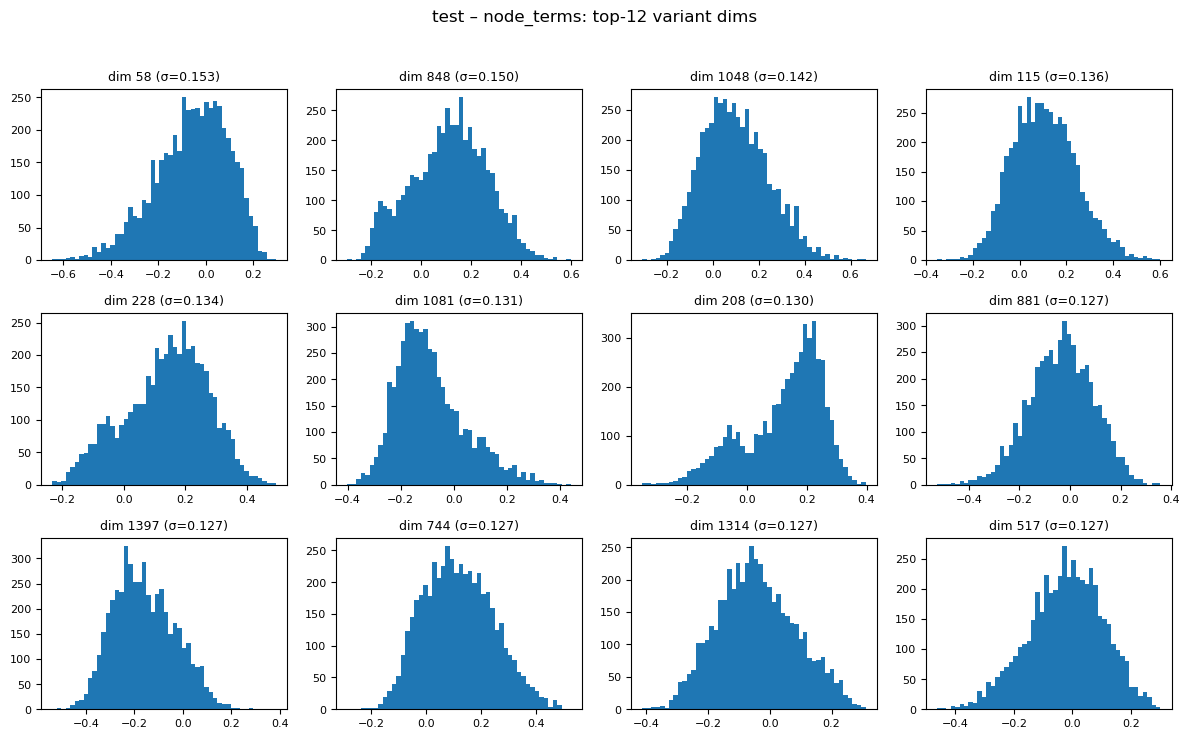

{'dataset': 'test',
 'edges': {'max': 13.0,
           'mean': 9.417,
           'median': 9.0,
           'min': 1.0,
           'n': 5000,
           'std': 1.155931760809058},
 'logp': {'max': 3.4686999320983887,
          'mean': 0.3070138343619852,
          'median': 0.27950000762939453,
          'min': -3.6511099338531494,
          'n': 5000,
          'std': 0.9605054019158015},
 'node_type_distribution': {(0, 0, 0, 1): 525,
                            (0, 0, 0, 2): 3,
                            (0, 0, 0, 3): 4288,
                            (0, 1, 0, 0): 1534,
                            (0, 1, 0, 1): 3191,
                            (0, 1, 0, 2): 8555,
                            (0, 1, 1, 1): 2,
                            (0, 2, 0, 0): 3672,
                            (0, 2, 0, 1): 7543,
                            (0, 2, 1, 0): 6,
                            (0, 3, 0, 0): 2276,
                            (1, 0, 0, 0): 665,
                            (1, 0, 0, 1): 4

In [2]:
from src.datasets.qm9_smiles_generation import QM9Smiles
from src.encoding.configs_and_constants import QM9_SMILES_HRR_1600_CONFIG_F64_G1G3_CONFIG
from pprint import pprint

for split in ["train", "valid", "test"]:
    ds = QM9Smiles(split=split, enc_suffix=QM9_SMILES_HRR_1600_CONFIG_F64_G1G3_CONFIG.name)
    stats = analyze_dataset(ds, name=split)
    pprint(stats)

### Generated Plots

[HDCGenerator] is using device: cpu
Generator Checkpoint: /home/akaveh/Projects/kit/graph_hdc/_models/0_real_nvp_v2/nvp_QM9SmilesHRR1600F64G1G3_f15_lr0.000160949_wd3e-6_bs224_an/models/epoch652-val-10279.9490.ckpt
Loading existing HyperNet from /home/akaveh/Projects/kit/graph_hdc/_models/hypernet_QM9SmilesHRR1600F64G1G3_HRR_dim1600_s42_depth3_ecb0-f64.pt


/home/akaveh/Projects/kit/graph_hdc/.pixi/envs/local/lib/python3.11/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/akaveh/Projects/kit/graph_hdc/.pixi/envs/local/lib/python3.11/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


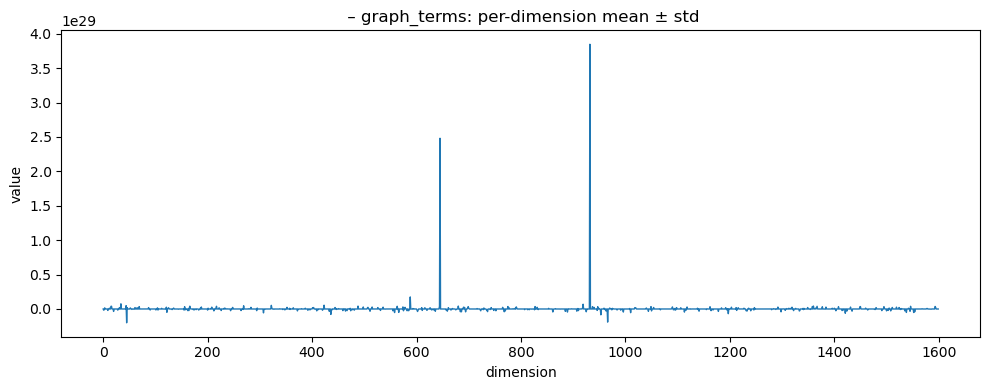

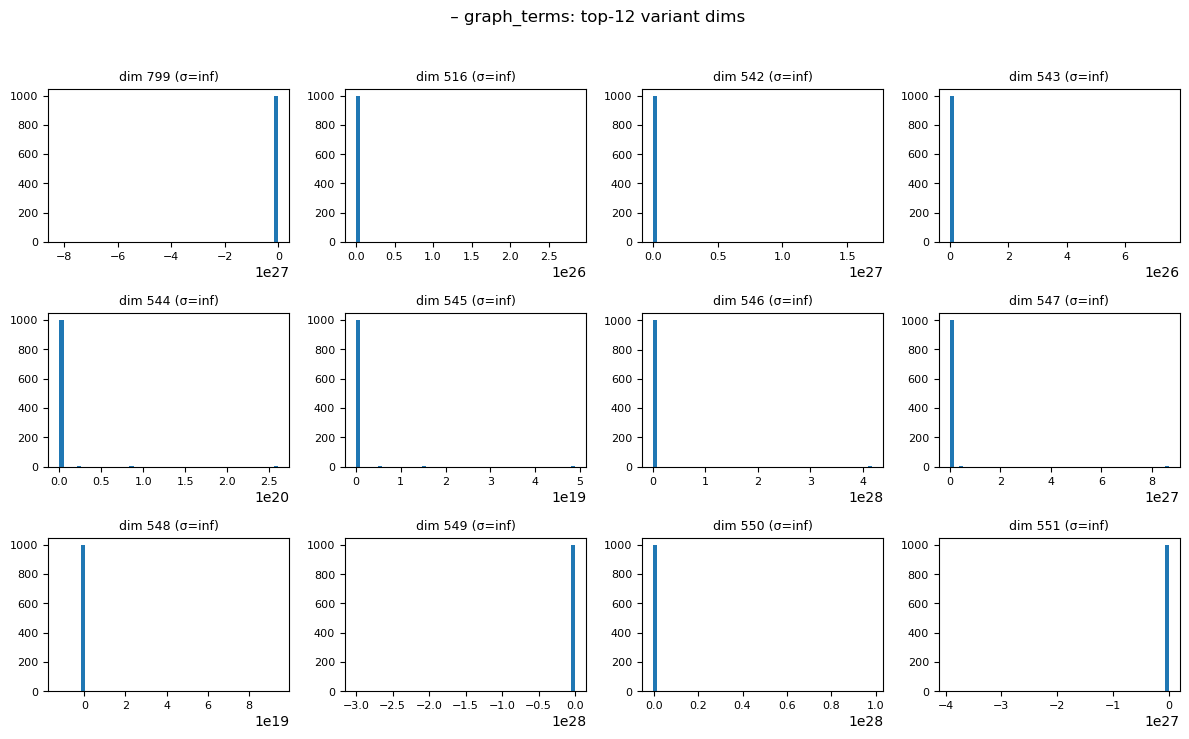

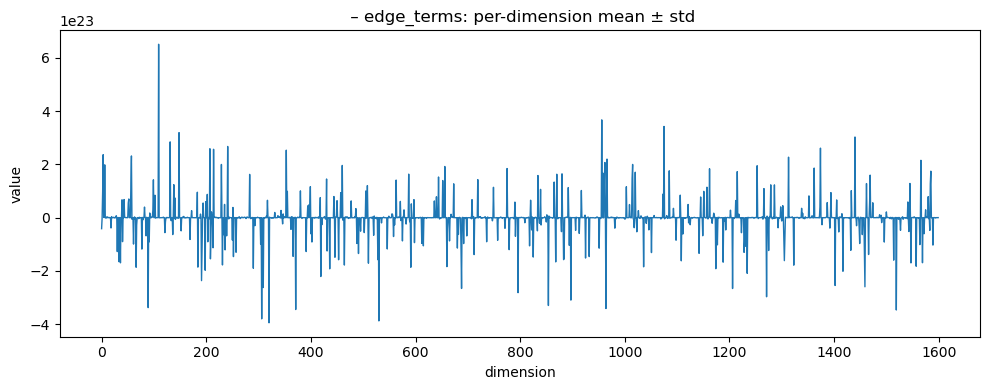

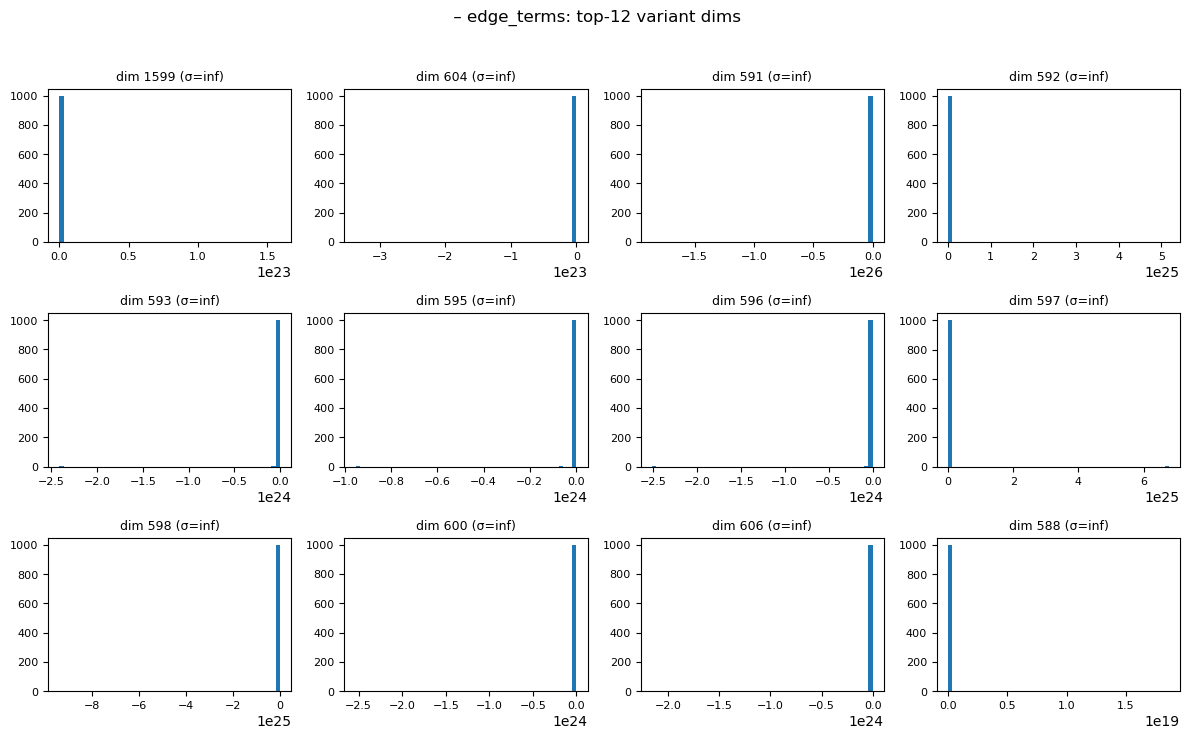

{'dataset': '',
 'terms': {'graph_terms': {'N': 1000, 'D': 1600},
  'edge_terms': {'N': 1000, 'D': 1600}}}

In [8]:
generator = HDCGenerator(
    gen_model_hint="nvp_QM9SmilesHRR1600F64G1G3_f15_lr0.000160949_wd3e-6_bs224_an",
    ds_config=QM9_SMILES_HRR_1600_CONFIG_F64_G1G3_CONFIG, device=torch.device("cpu"))
samples = generator.get_raw_samples(n_samples=1000)
analyze_terms_only(terms=samples)

## QM9_SMILES_HRR_1600_CONFIG_F64_G1NG3_CONFIG

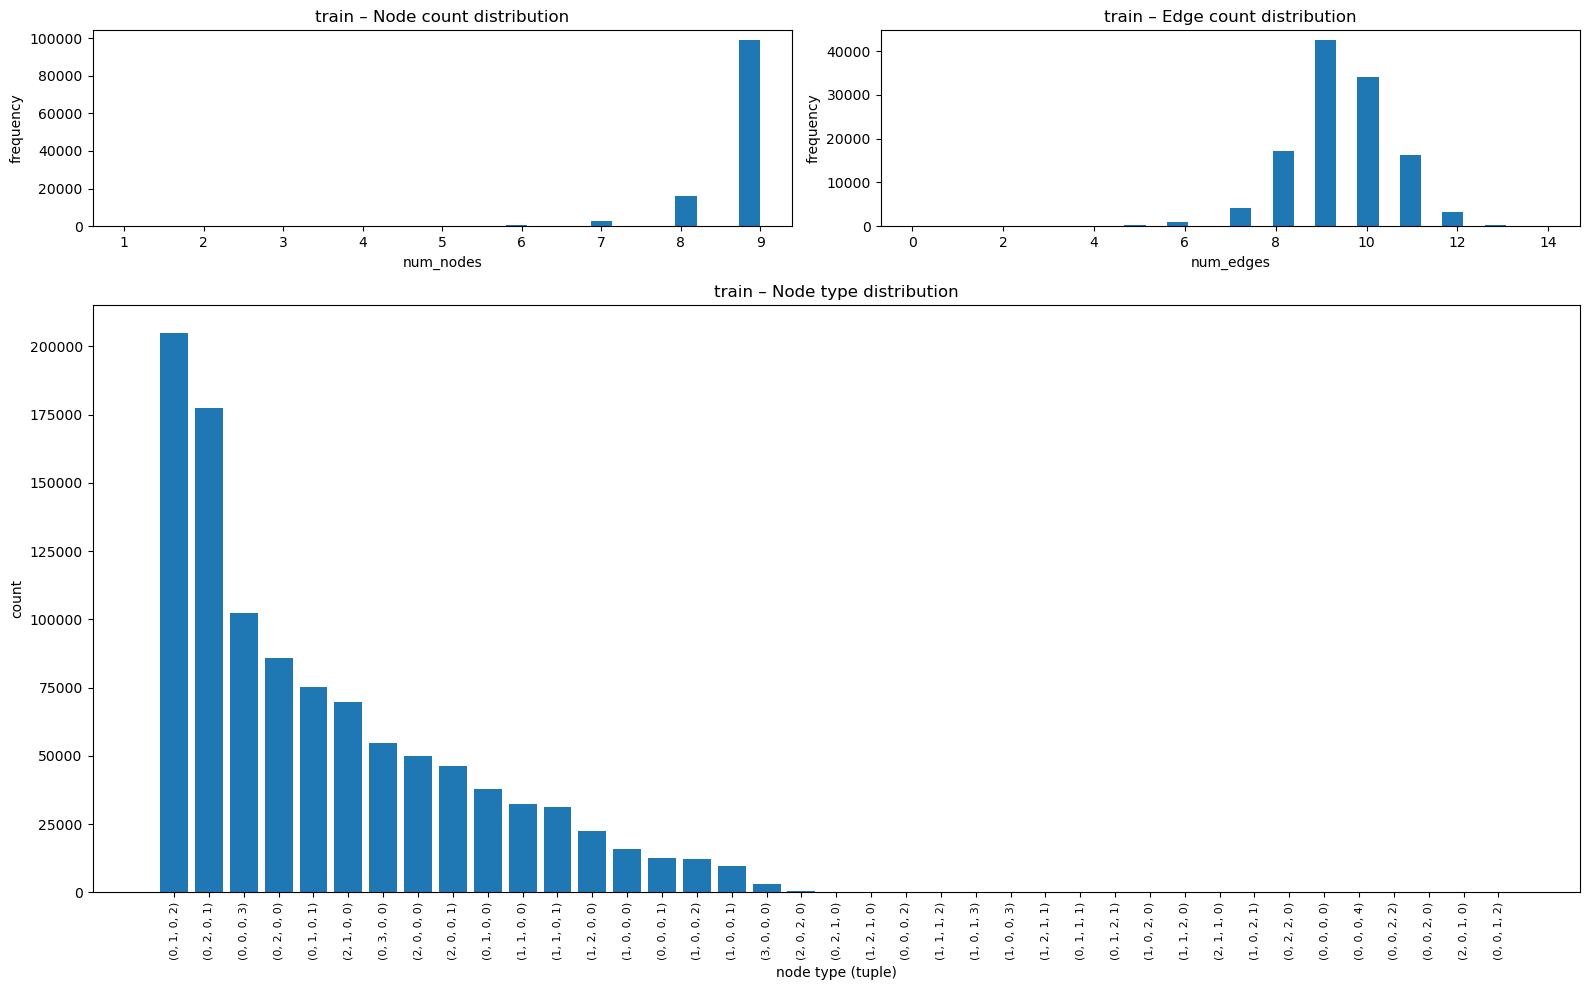

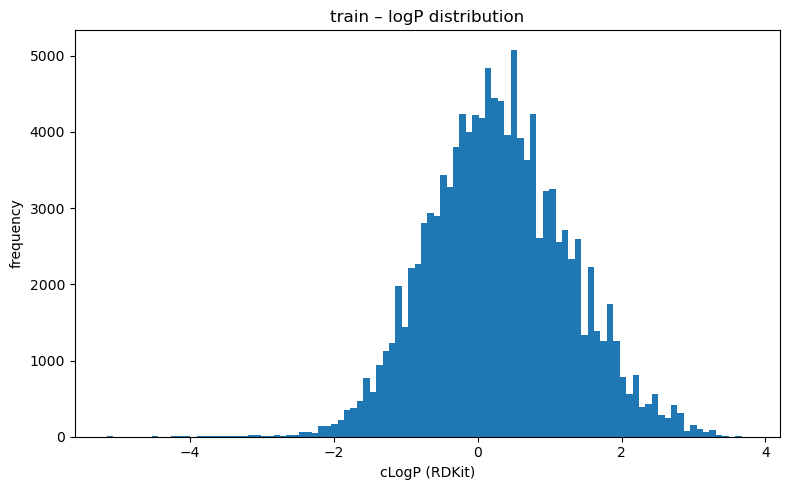

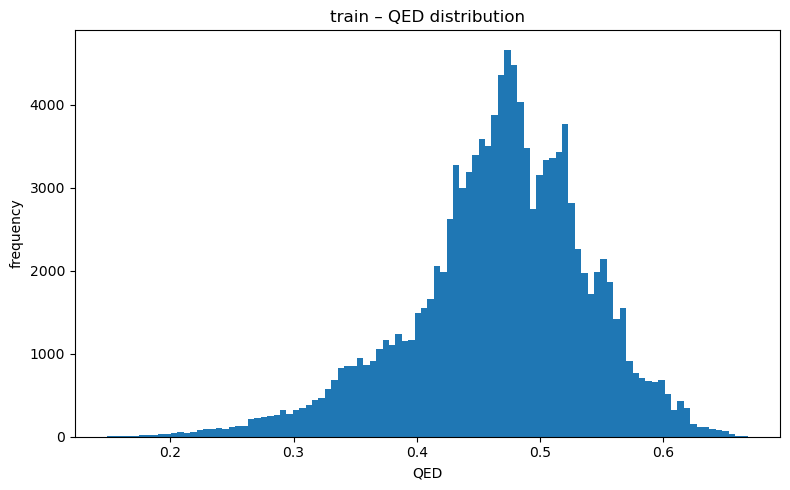

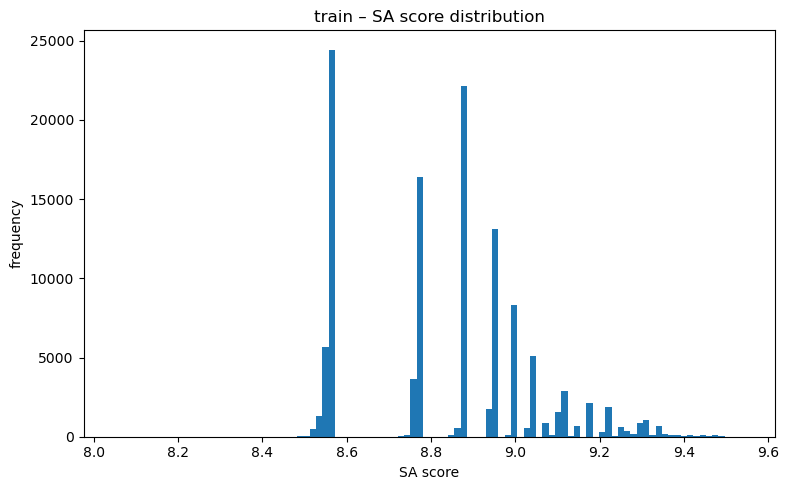

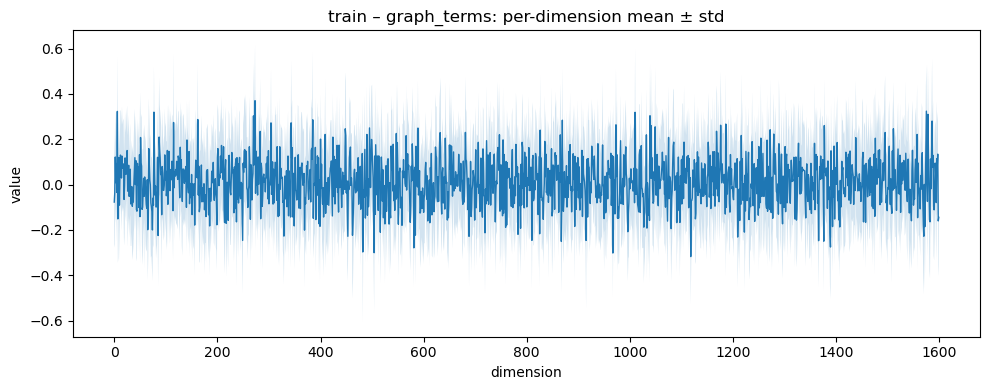

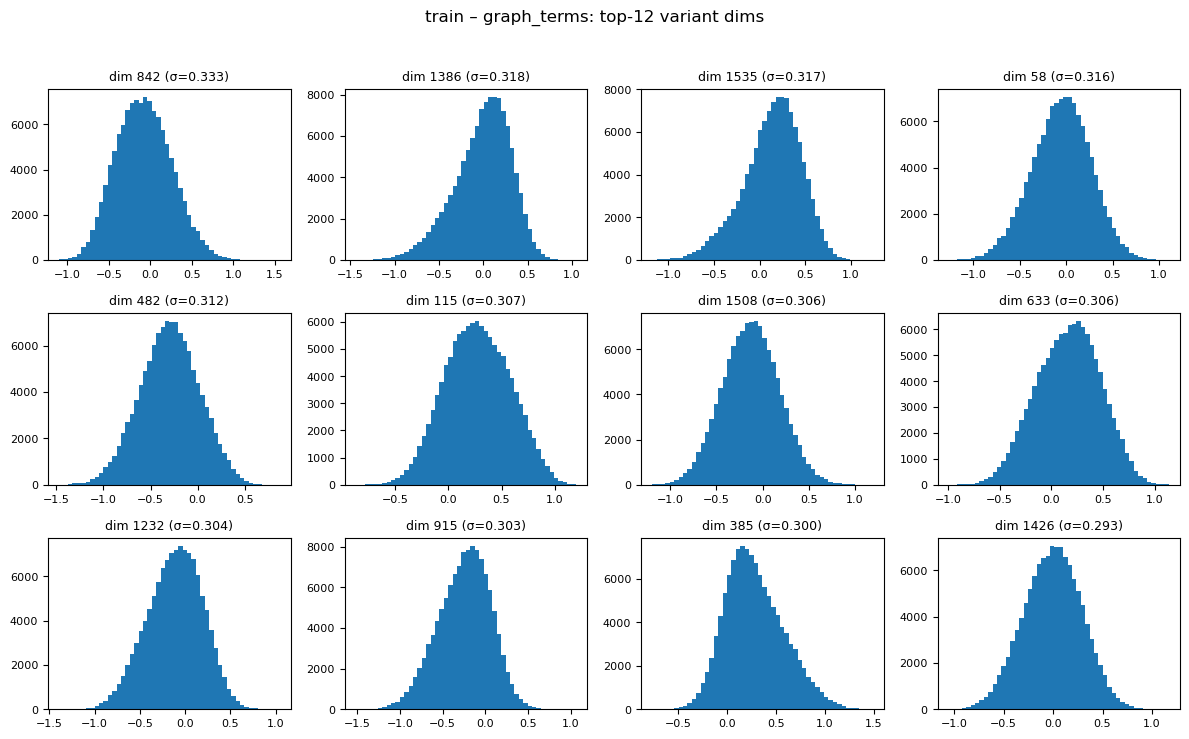

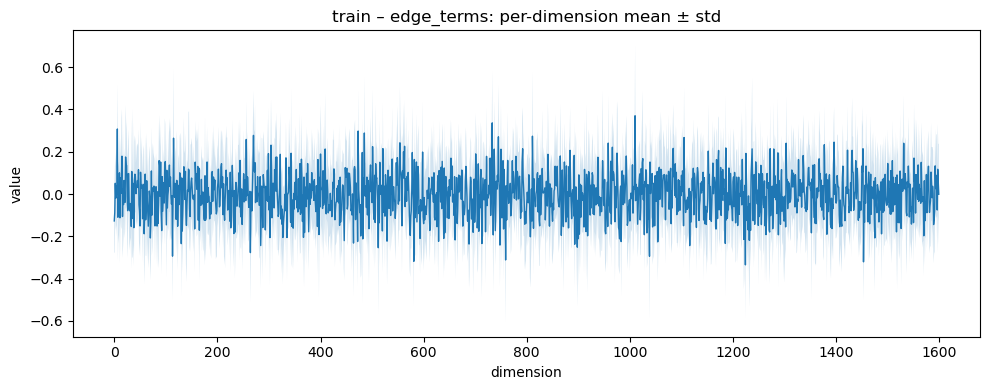

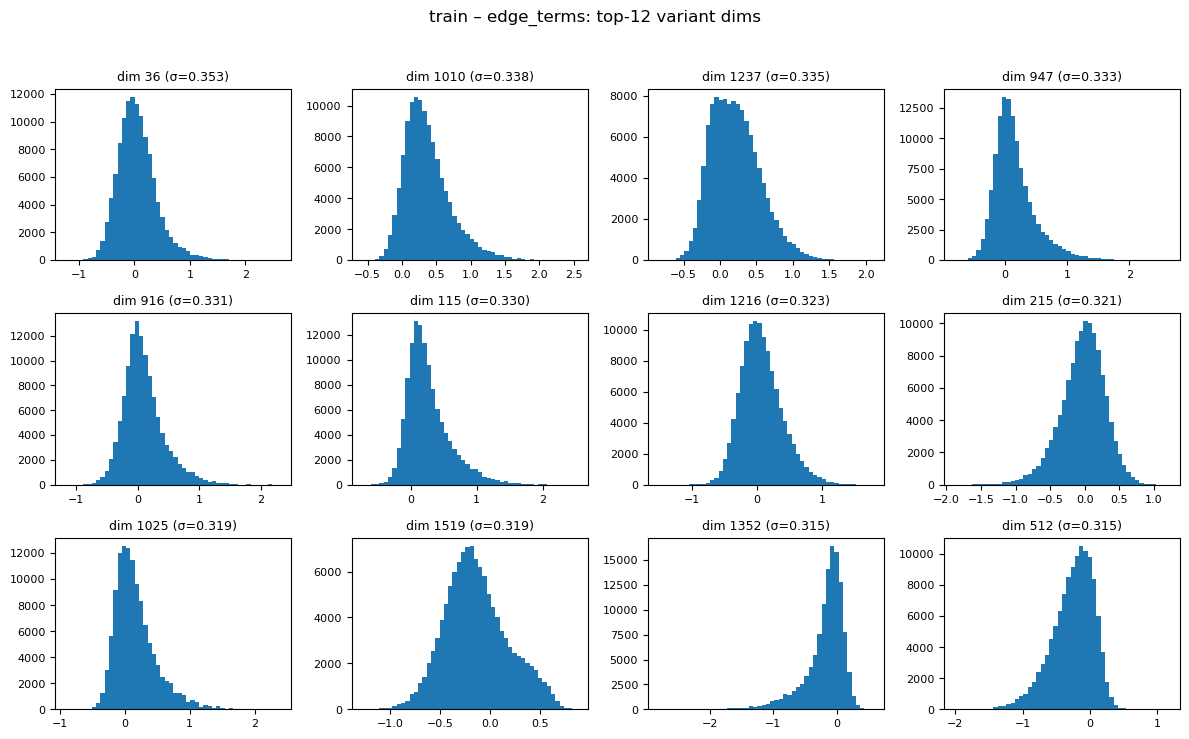

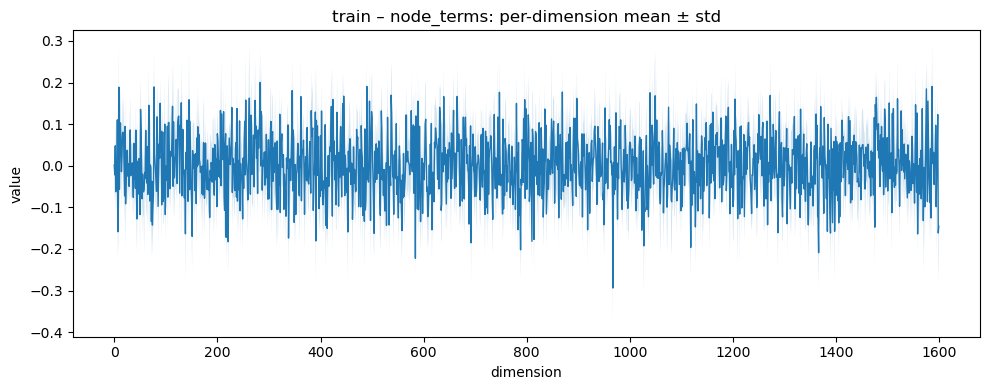

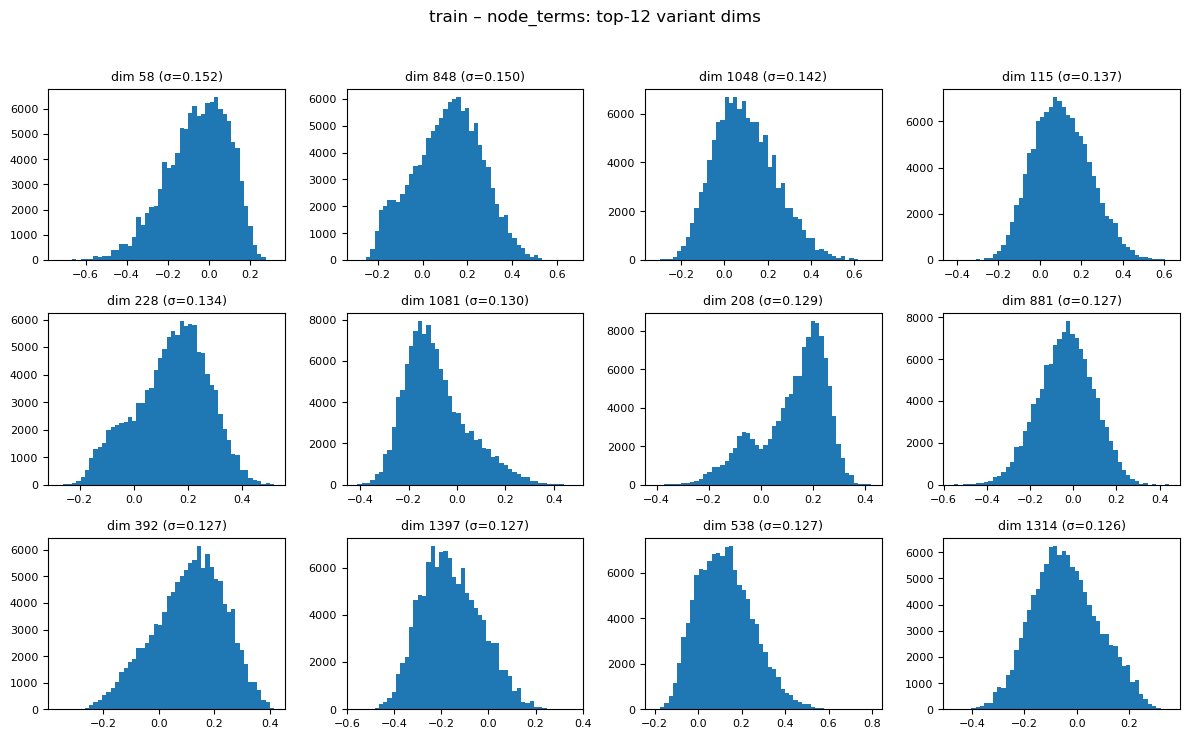

{'dataset': 'train',
 'edges': {'max': 14.0,
           'mean': 9.396537655935868,
           'median': 9.0,
           'min': 0.0,
           'n': 118879,
           'std': 1.1682700245850308},
 'logp': {'max': 3.7569000720977783,
          'mean': 0.30487121410781287,
          'median': 0.27810001373291016,
          'min': -5.1546101570129395,
          'n': 118879,
          'std': 0.9661976604136703},
 'node_type_distribution': {(0, 0, 0, 0): 2,
                            (0, 0, 0, 1): 12653,
                            (0, 0, 0, 2): 92,
                            (0, 0, 0, 3): 102500,
                            (0, 0, 0, 4): 1,
                            (0, 0, 1, 2): 1,
                            (0, 0, 2, 0): 1,
                            (0, 0, 2, 2): 1,
                            (0, 1, 0, 0): 37875,
                            (0, 1, 0, 1): 75277,
                            (0, 1, 0, 2): 204962,
                            (0, 1, 1, 1): 24,
                         

In [3]:
from src.datasets.qm9_smiles_generation import QM9Smiles
from src.encoding.configs_and_constants import QM9_SMILES_HRR_1600_CONFIG_F64_G1NG3_CONFIG
from pprint import pprint

for split in ["train"]:
    ds = QM9Smiles(split=split, enc_suffix=QM9_SMILES_HRR_1600_CONFIG_F64_G1NG3_CONFIG.name)
    stats = analyze_dataset(ds, name=split)
    pprint(stats)

### Generative Plots

[HDCGenerator] is using device: cpu
Generator Checkpoint: /home/akaveh/Projects/kit/graph_hdc/_models/0_real_nvp_v2/nvp_QM9SmilesHRR1600F64G1NG3_f16_lr0.000525421_wd0.0005_bs256_an/models/epoch314-val-16501.2308.ckpt
Loading existing HyperNet from /home/akaveh/Projects/kit/graph_hdc/_models/hypernet_QM9SmilesHRR1600F64G1NG3_HRR_dim1600_s42_depth3_ecb0-f64.pt


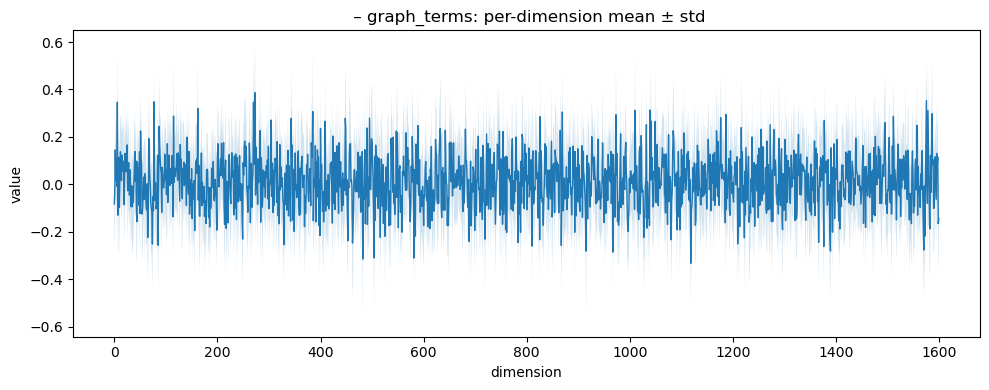

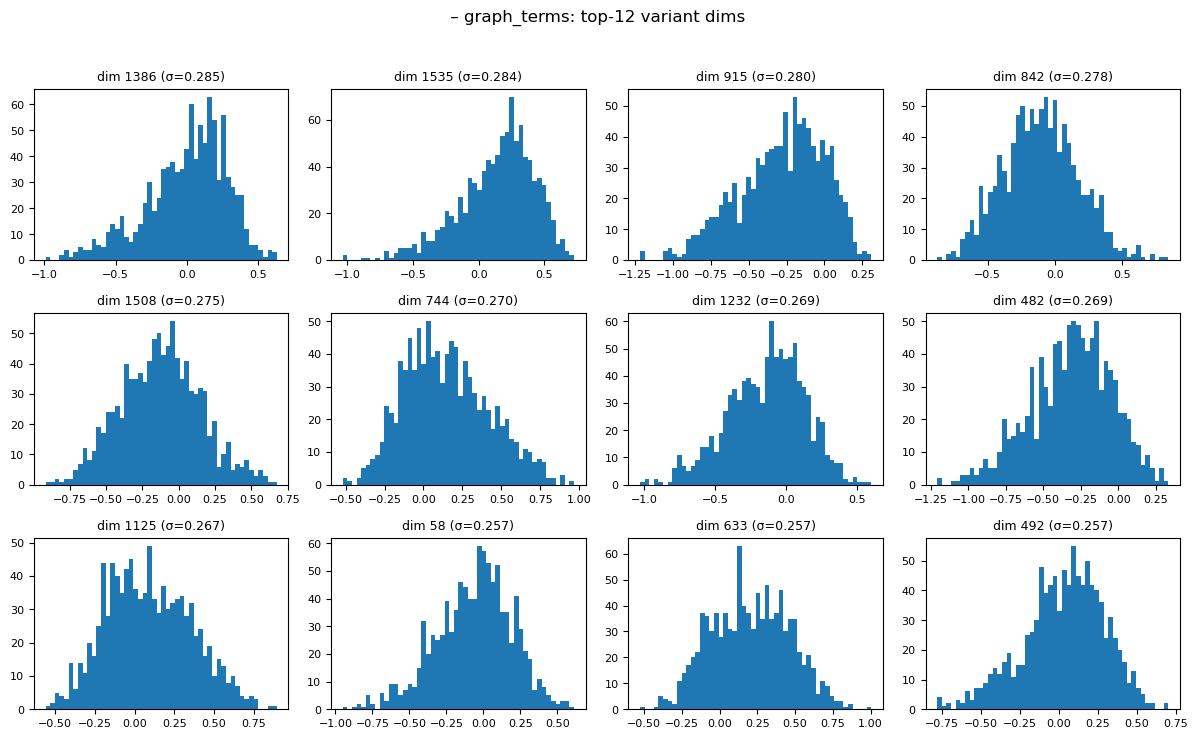

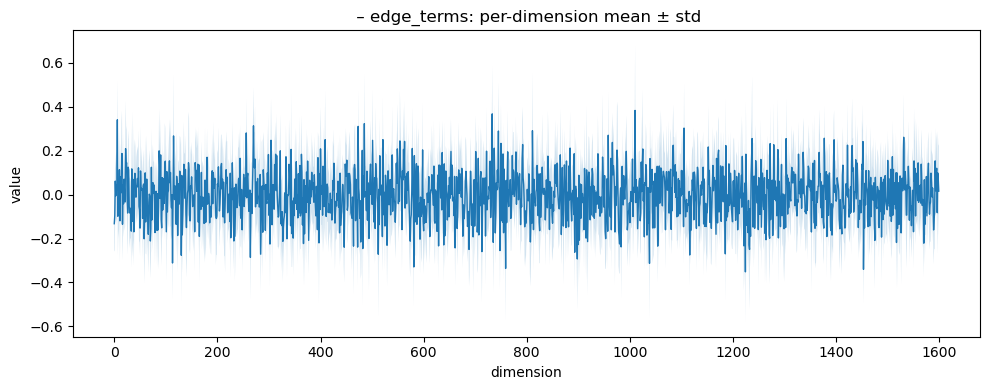

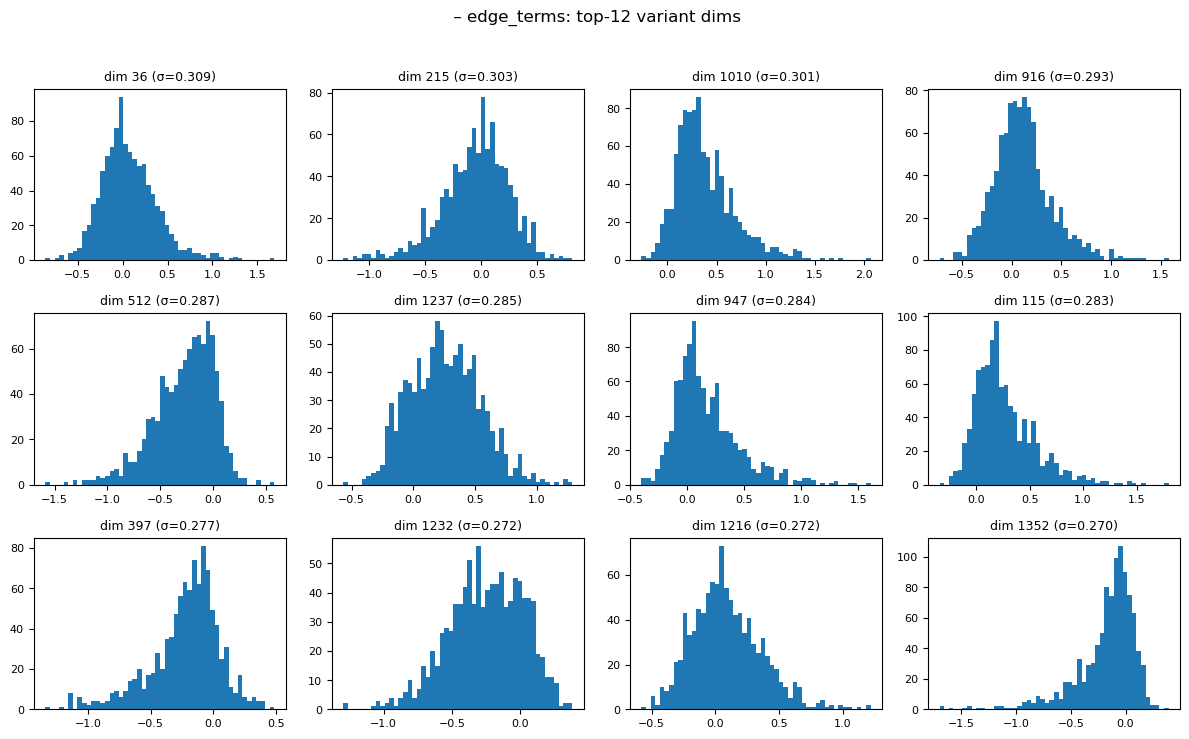

{'dataset': '',
 'terms': {'graph_terms': {'N': 1000, 'D': 1600},
  'edge_terms': {'N': 1000, 'D': 1600}}}

In [9]:
generator = HDCGenerator(
    gen_model_hint="nvp_QM9SmilesHRR1600F64G1NG3_f16_lr0.000525421_wd0.0005_bs256_an",
    ds_config=QM9_SMILES_HRR_1600_CONFIG_F64_G1NG3_CONFIG, device=torch.device("cpu"))
samples = generator.get_raw_samples(n_samples=1000)
analyze_terms_only(terms=samples)

## ZINC_SMILES_HRR_6144_G1G4_CONFIG

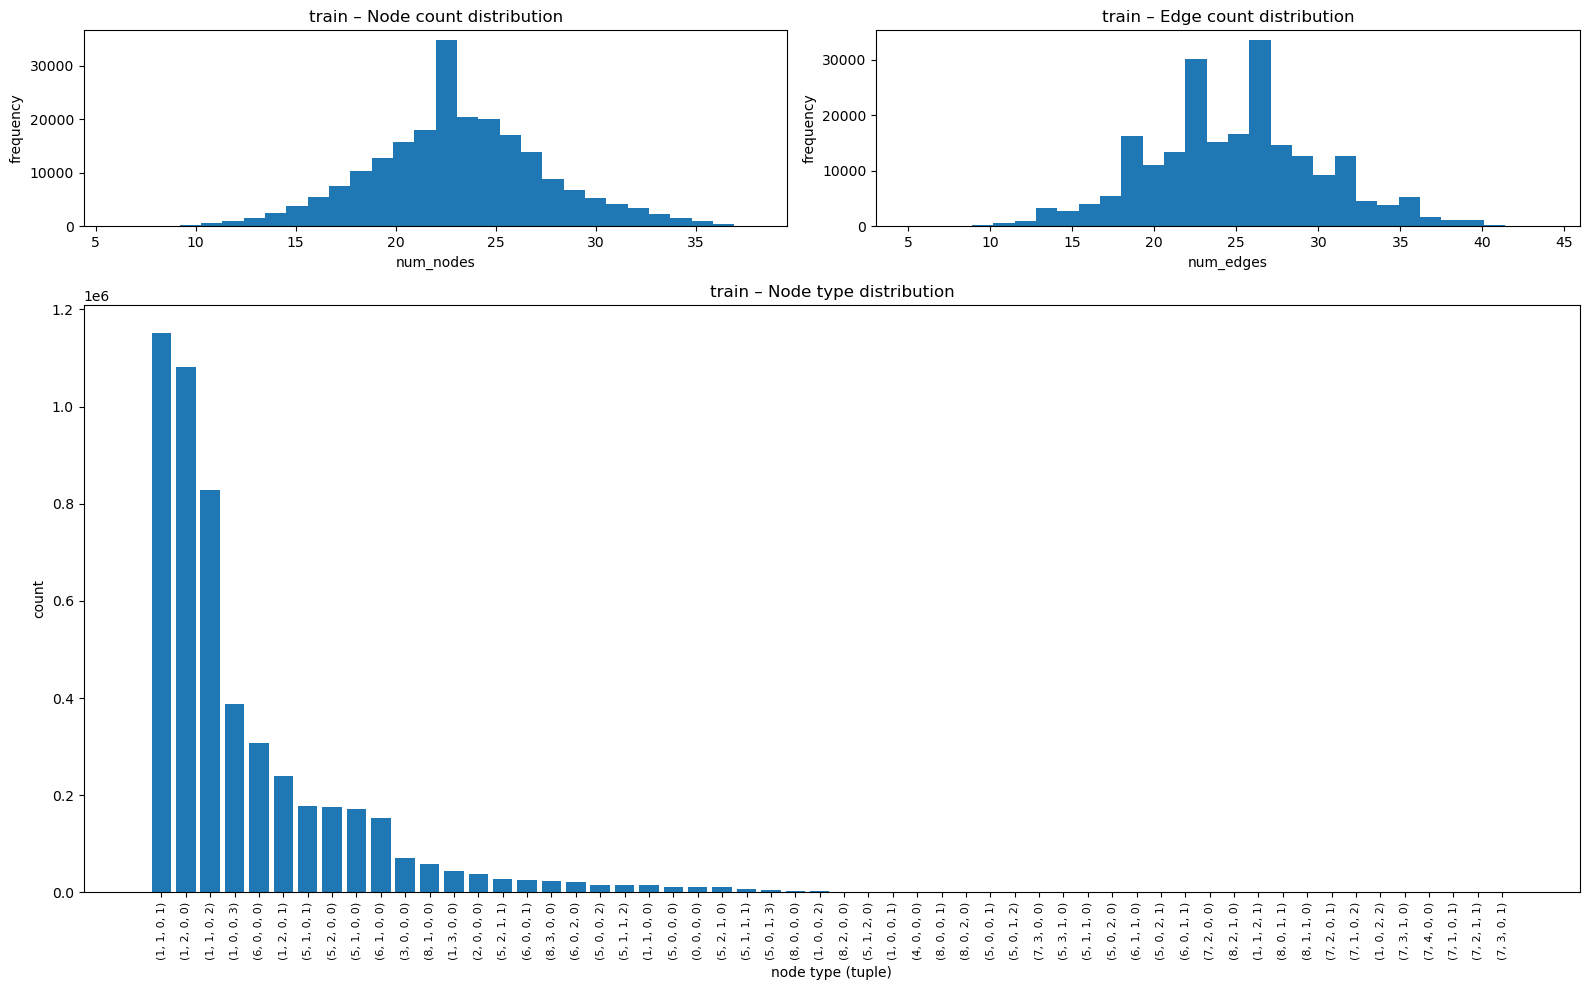

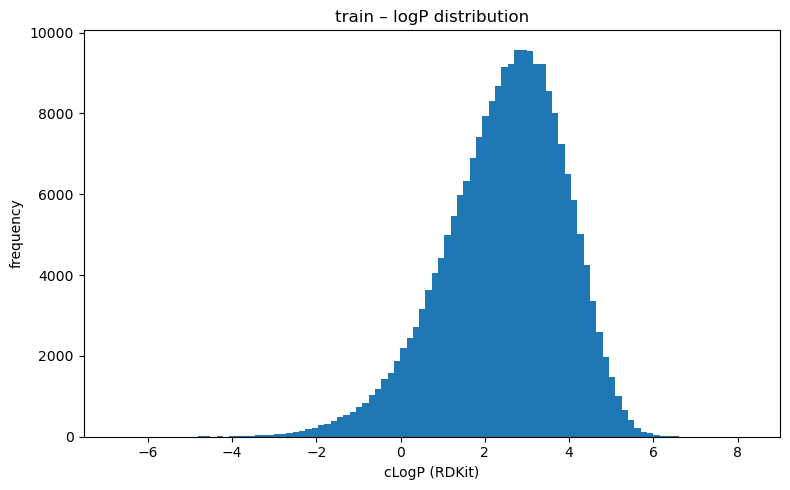

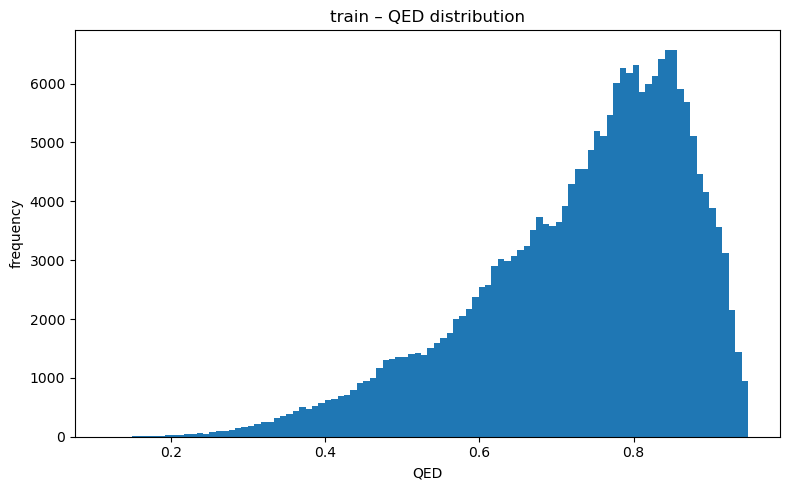

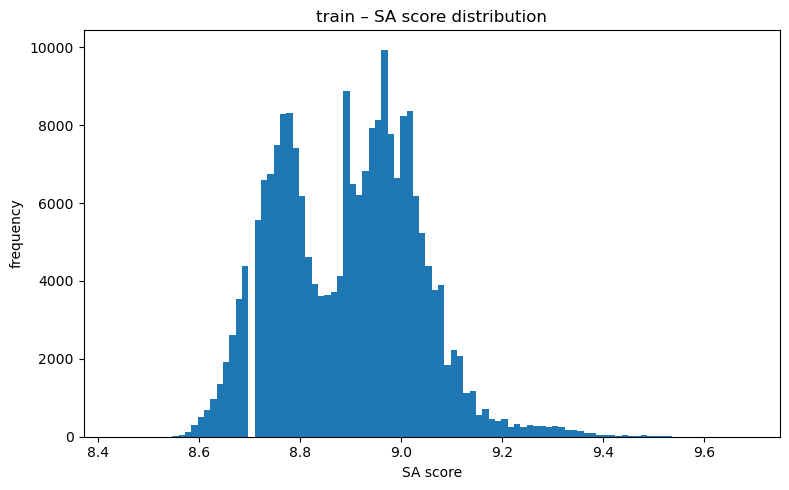

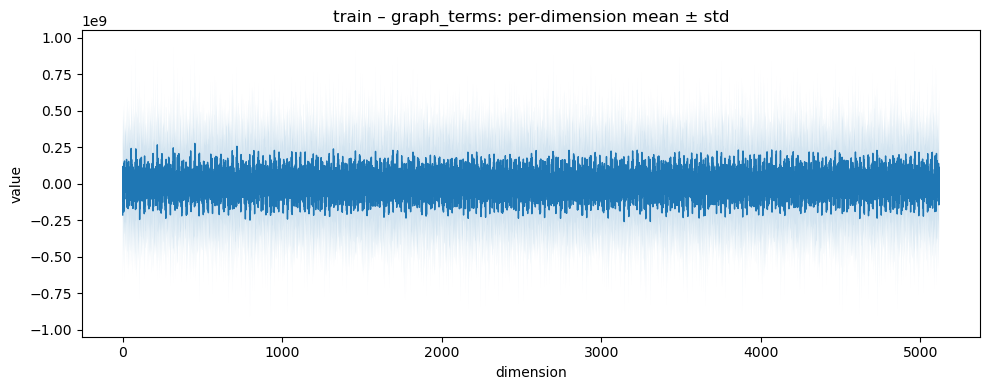

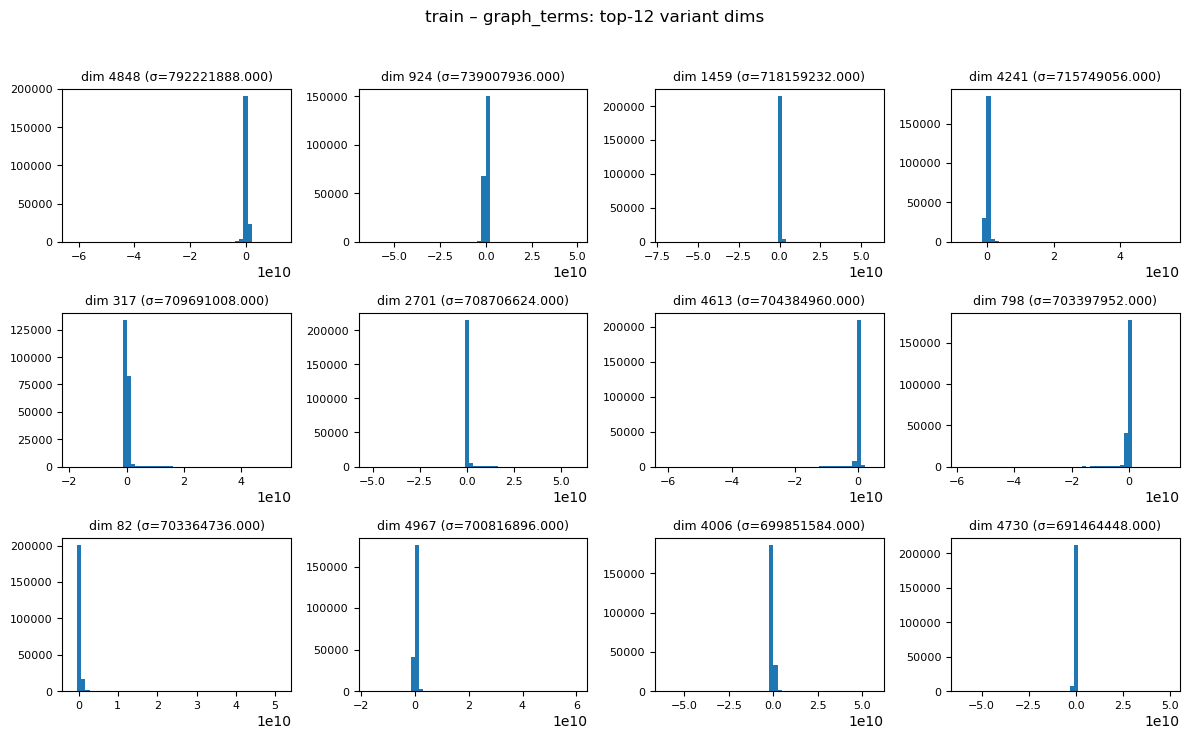

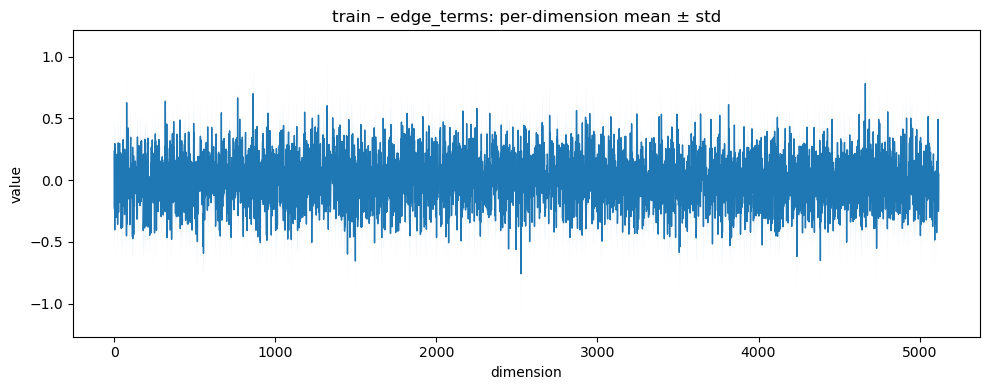

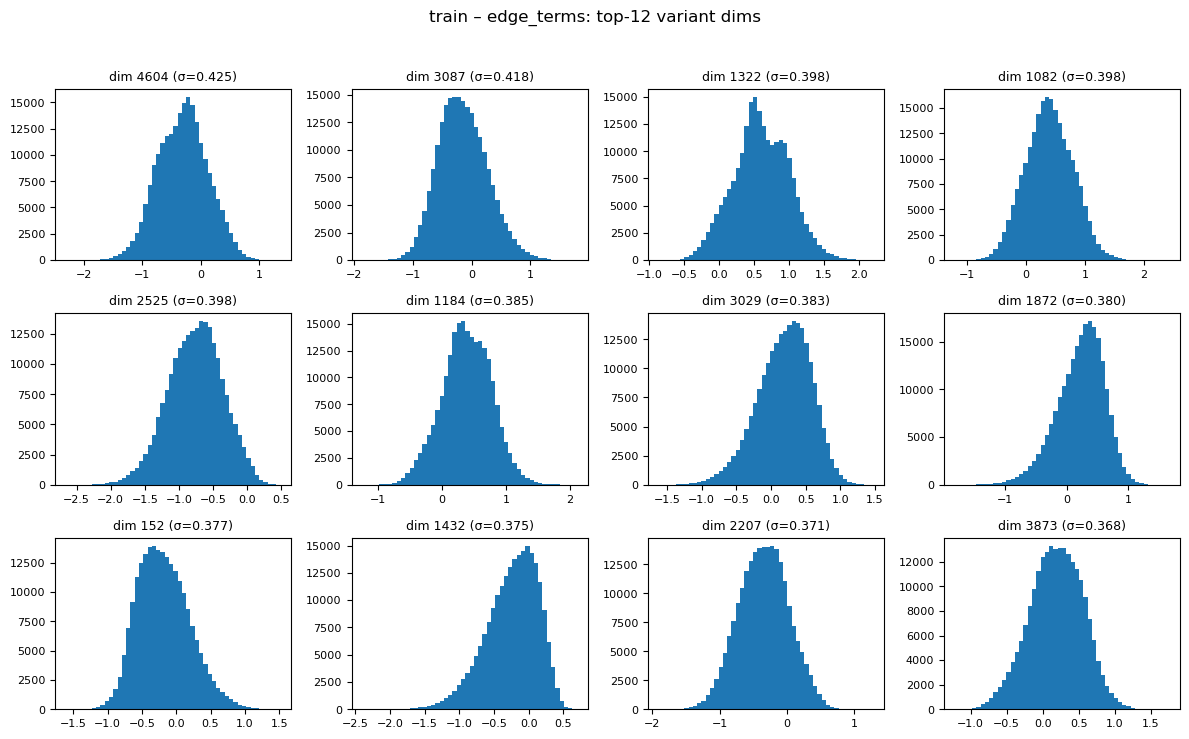

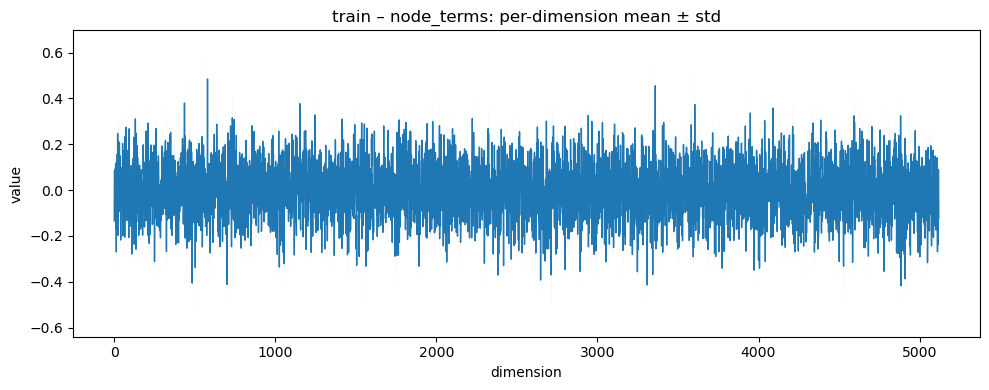

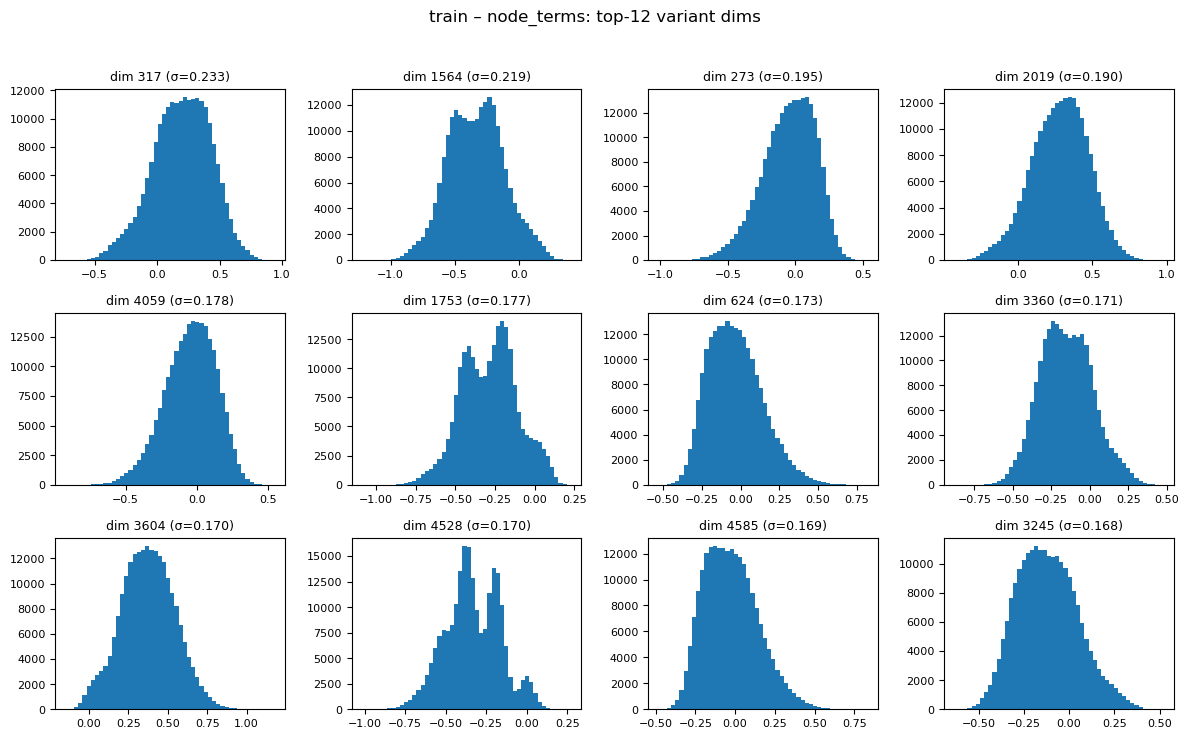

{'dataset': 'train',
 'edges': {'max': 44.0,
           'mean': 24.906559217493673,
           'median': 25.0,
           'min': 5.0,
           'n': 220011,
           'std': 5.2931777992057825},
 'logp': {'max': 8.252099990844727,
          'mean': 2.457799800788871,
          'median': 2.60617995262146,
          'min': -6.771599769592285,
          'n': 220011,
          'std': 1.4334213538628746},
 'node_type_distribution': {(0, 0, 0, 0): 11241,
                            (1, 0, 0, 1): 1147,
                            (1, 0, 0, 2): 2770,
                            (1, 0, 0, 3): 388718,
                            (1, 0, 2, 2): 1,
                            (1, 1, 0, 0): 14353,
                            (1, 1, 0, 1): 1151482,
                            (1, 1, 0, 2): 828684,
                            (1, 1, 2, 1): 2,
                            (1, 2, 0, 0): 1082358,
                            (1, 2, 0, 1): 239485,
                            (1, 3, 0, 0): 44634,
         

In [4]:
from src.datasets.zinc_smiles_generation import ZincSmiles
from src.encoding.configs_and_constants import ZINC_SMILES_HRR_6144_G1G4_CONFIG
from pprint import pprint

for split in ["train"]:
    ds = ZincSmiles(split=split, enc_suffix=ZINC_SMILES_HRR_6144_G1G4_CONFIG.name)
    stats = analyze_dataset(ds, name=split)
    pprint(stats)

In [ ]:
generator = HDCGenerator(gen_model_hint="")